# METRO TRAFFIC VOLUME FORECASTING
## Machine Learning Project
#### Noémie MAZEPA, Lorrain MORLET, Auriane MARCELINO, Aymeric MARTIN

# <h2 style="color:blue">STAGE 1</h2>

## Imports 

We import everything we will need afterwards in this block. It's easier and cleaner to do it this way.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from sklearn.metrics import root_mean_squared_error

c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## EDA

We start by uploading the CSV file that we will work on and we display some basic information about the dataset such as the first couple of lines, the number of null values and the type of each column. This way we can easily grasp what is going on and see what can be done during pre-processing.

In [2]:
df=pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=",")
df.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

So far we have 9 columns and our target column is traffic_volume.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


First we notice that the column holiday is missing a lot of values. Actually it's not really missing values but rather the way the dataset was built set the days that were not holidays as None. We will need to change this notation later.

We also notice that we have 4 columns with the object type, 3 columns with the float type and finally 2 columns with the int type. However, the column date_time should be with the type datetime, so we'll change that as well.

In [4]:
df.describe()

temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000

In [5]:
df.isnull().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

The good thing is that apart from the holiday column, there are no missing values and that the missing values in the holiday column are easily handled.

## Pre-process

After visualizing our dataset and its different informations, we begin the pre-processing.

The holiday column has many missing values, and the only rows with a value contain the name of a specific holiday. This isn't very useful, so we'll simply create bins: 0 for non-holiday and 1 for holiday.

In [6]:
df['holiday'] = df['holiday'].fillna(0)
df['holiday'] = df['holiday'].apply(lambda x: 1 if x != 0 else 0)
df.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0        0  288.28      0.0      0.0          40       Clouds   
1        0  289.36      0.0      0.0          75       Clouds   
2        0  289.58      0.0      0.0          90       Clouds   
3        0  290.13      0.0      0.0          90       Clouds   
4        0  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

In [7]:
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

We can check that there are no missing values anymore.

Just in case, we will also suppress all duplicates.

In [8]:
df = df.drop_duplicates()

The temperature in the temp column is in Kelvin which isn't very comprehensible to us. It's not going to change anything to convert it in Celsius but we will do it because it is easier to understand the values.

In [9]:
df['temp'] = df['temp'] - 273.15
df.head()

holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
0        0  15.13      0.0      0.0          40       Clouds   
1        0  16.21      0.0      0.0          75       Clouds   
2        0  16.43      0.0      0.0          90       Clouds   
3        0  16.98      0.0      0.0          90       Clouds   
4        0  17.99      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

Now we are focusing on the days: the specific day number (like the 10th or the 23rd) is not important. Something that would be more relevant is knowing if it is a Monday, Tuesday, etc., and then whether it's a weekday or weekend. To do this we will convert the column date_time to the type datetime to then extract the date, the hour, the year, the month and the day.

For the hour, we only take the first part because the data is always taken at full hours like 9:00 or 21:00.

For the day, we use dt.dayoftheweek to get a value depending on the date: 1 for Monday, 2 for Tuesday, etc. Once we have this, we can determine if the day is a week day or weekend: if the number is between 1 and 5 it's the week and if the number is 6 or 7, it's the weekend.

In [10]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['date']=df['date_time'].dt.date.astype('datetime64[ns]')
df['hour'] = df['date_time'].dt.hour
df['year']=df['date_time'].dt.year
df['month']=df['date_time'].dt.month
df['day'] = df['date_time'].dt.dayofweek
df['is_weekend'] = df['day'].apply(lambda x: 1 if x >= 5 else 0)
df=df.drop('date_time', axis=1)
df.head()

holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
0        0  15.13      0.0      0.0          40       Clouds   
1        0  16.21      0.0      0.0          75       Clouds   
2        0  16.43      0.0      0.0          90       Clouds   
3        0  16.98      0.0      0.0          90       Clouds   
4        0  17.99      0.0      0.0          75       Clouds   

  weather_description  traffic_volume       date  hour  year  month  day  \
0    scattered clouds            5545 2012-10-02     9  2012     10    1   
1       broken clouds            4516 2012-10-02    10  2012     10    1   
2     overcast clouds            4767 2012-10-02    11  2012     10    1   
3     overcast clouds            5026 2012-10-02    12  2012     10    1   
4       broken clouds            4918 2012-10-02    13  2012     10    1   

   is_weekend  
0           0  
1           0  
2           0  
3           0  
4           0

We want to create categories to describe the different parts of the day. We think that depending on the period of the day, the traffic volume can change: for example, during the night there are not many people taking the metro but in the morning a lot of people go to work, etc.

We thought it would be more relevant categorize the hours rather than study the volume hour by hour.

In [11]:
def classifier_day(hour):
    if 6 <= hour < 10:
        return 'Morning'
    elif 10 <= hour < 12:
        return 'Late morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Late afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    elif 22 <= hour <=23 or 0<=hour<6:
        return 'Night'

df['part_of_the_day'] = df['hour'].apply(classifier_day)
df.head(20)

holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
0         0  15.13      0.0      0.0          40       Clouds   
1         0  16.21      0.0      0.0          75       Clouds   
2         0  16.43      0.0      0.0          90       Clouds   
3         0  16.98      0.0      0.0          90       Clouds   
4         0  17.99      0.0      0.0          75       Clouds   
5         0  18.57      0.0      0.0           1        Clear   
6         0  20.02      0.0      0.0           1        Clear   
7         0  20.71      0.0      0.0           1        Clear   
8         0  20.99      0.0      0.0          20       Clouds   
9         0  19.95      0.0      0.0          20       Clouds   
10        0  17.82      0.0      0.0          20       Clouds   
11        0  16.23      0.0      0.0           1        Clear   
12        0  15.46      0.0      0.0           1        Clear   
13        0  14.01      0.0      0.0           1        Clear   
14        0  12.30      0.0      0.0           1        Clear   
15        0  11.48      0.0      0.0           1        Clear   
16        0  10.32      0.0      0.0           1        Clear   
17        0   8.03      0.0      0.0           1        Clear   
18        0   7.94      0.0      0.0           1        Clear   
19        0   6.38      0.0      0.0           1        Clear   

   weather_description  traffic_volume       date  hour  year  month  day  \
0     scattered clouds            5545 2012-10-02     9  2012     10    1   
1        broken clouds            4516 2012-10-02    10  2012     10    1   
2      overcast clouds            4767 2012-10-02    11  2012     10    1   
3      overcast clouds            5026 2012-10-02    12  2012     10    1   
4        broken clouds            4918 2012-10-02    13  2012     10    1   
5         sky is clear            5181 2012-10-02    14  2012     10    1   
6         sky is clear            5584 2012-10-02    15  2012     10    1   
7         sky is clear            6015 2012-10-02    16  2012     10    1   
8           few clouds            5791 2012-10-02    17  2012     10    1   
9           few clouds            4770 2012-10-02    18  2012     10    1   
10          few clouds            3539 2012-10-02    19  2012     10    1   
11        sky is clear            2784 2012-10-02    20  2012     10    1   
12        sky is clear            2361 2012-10-02    21  2012     10    1   
13        sky is clear            1529 2012-10-02    22  2012     10    1   
14        sky is clear             963 2012-10-02    23  2012     10    1   
15        sky is clear             506 2012-10-03     0  2012     10    2   
16        sky is clear             321 2012-10-03     1  2012     10    2   
17        sky is clear             273 2012-10-03     2  2012     10    2   
18        sky is clear             367 2012-10-03     3  2012     10    2   
19        sky is clear             814 2012-10-03     4  2012     10    2   

    is_weekend part_of_the_day  
0            0         Morning  
1            0    Late morning  
2            0    Late morning  
3            0       Afternoon  
4            0       Afternoon  
5            0       Afternoon  
6            0  Late afternoon  
7            0  Late afternoon  
8            0  Late afternoon  
9            0         Evening  
10           0         Evening  
11           0         Evening  
12           0         Evening  
13           0           Night  
14           0           Night  
15           0           Night  
16           0           Night  
17           0           Night  
18           0           Night  
19           0           Night

We have a problem with the holidays. We noticed that the days being holidays were only marked as holidays for one hour, usually at midnight. We need to solve this by getting all the dates where the day is a holiday and placing them in the holiday_dtaes variable. Then, we search in the whole holiday column, all the lines with a date in the holiday_dates variable and put a one in the holiday column if that is the case. That way we locate all the days that should be marked as a holiday and now the entire day and not just an hour is marked as a holiday.

In [12]:
holiday_dates = df[df['holiday'] == 1]['date'].unique()
df['holiday'] = df['date'].isin(holiday_dates).astype(int)
df.iloc[125:151]

holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
125        0   0.77      0.0      0.0          20       Clouds   
126        1  -0.07      0.0      0.0          20       Clouds   
127        1  -0.53      0.0      0.0          20       Clouds   
128        1  -1.37      0.0      0.0           1        Clear   
129        1  -2.10      0.0      0.0           1        Clear   
130        1  -2.52      0.0      0.0           1        Clear   
131        1  -2.82      0.0      0.0           1        Clear   
132        1  -3.54      0.0      0.0          20       Clouds   
133        1  -3.14      0.0      0.0          20       Clouds   
134        1  -1.92      0.0      0.0          20       Clouds   
135        1   0.56      0.0      0.0          20       Clouds   
136        1   3.62      0.0      0.0          20       Clouds   
137        1   6.32      0.0      0.0          20       Clouds   
138        1   6.69      0.0      0.0           1        Clear   
139        1   9.19      0.0      0.0          40       Clouds   
140        1   9.79      0.0      0.0          40       Clouds   
141        1  10.33      0.0      0.0           1        Clear   
142        1  11.18      0.0      0.0           1        Clear   
143        1  11.33      0.0      0.0          40       Clouds   
144        1  11.08      0.0      0.0          40       Clouds   
145        1   8.84      0.0      0.0          20       Clouds   
146        1   6.66      0.0      0.0           1        Clear   
147        1   6.20      0.0      0.0           1        Clear   
148        1   5.75      0.0      0.0           1        Clear   
149        1   5.31      0.0      0.0           1        Clear   
150        0   4.63      0.0      0.0           1        Clear   

    weather_description  traffic_volume       date  hour  year  month  day  \
125          few clouds             959 2012-10-07    23  2012     10    6   
126          few clouds             455 2012-10-08     0  2012     10    0   
127          few clouds             336 2012-10-08     1  2012     10    0   
128        sky is clear             265 2012-10-08     2  2012     10    0   
129        sky is clear             314 2012-10-08     3  2012     10    0   
130        sky is clear             779 2012-10-08     4  2012     10    0   
131        sky is clear            2571 2012-10-08     5  2012     10    0   
132          few clouds            5563 2012-10-08     6  2012     10    0   
133          few clouds            6676 2012-10-08     7  2012     10    0   
134          few clouds            5966 2012-10-08     8  2012     10    0   
135          few clouds            4832 2012-10-08     9  2012     10    0   
136          few clouds            4395 2012-10-08    10  2012     10    0   
137          few clouds            4411 2012-10-08    11  2012     10    0   
138        sky is clear            4648 2012-10-08    12  2012     10    0   
139    scattered clouds            4602 2012-10-08    13  2012     10    0   
140    scattered clouds            5125 2012-10-08    14  2012     10    0   
141        sky is clear            5502 2012-10-08    15  2012     10    0   
142        sky is clear            5979 2012-10-08    16  2012     10    0   
143    scattered clouds            5663 2012-10-08    17  2012     10    0   
144    scattered clouds            4259 2012-10-08    18  2012     10    0   
145          few clouds            3069 2012-10-08    19  2012     10    0   
146        sky is clear            2378 2012-10-08    20  2012     10    0   
147        sky is clear            2030 2012-10-08    21  2012     10    0   
148        sky is clear            1400 2012-10-08    22  2012     10    0   
149        sky is clear             917 2012-10-08    23  2012     10    0   
150        sky is clear             515 2012-10-09     0  2012     10    1   

     is_weekend part_of_the_day  
125           1           Night  
126           0           Night  
127          

As we can see fot this example, the whole day (2012-10-08) is now a holiday and not just at midnight.

We can also create seasons to categorize parts of the year. We could think that maybe, when it is summer and sunny outside, people tend to take the subway more because they go out more, etc. It is also interesting because as we can see below, this dataset covers 6 years: there will be recurrences.

In [13]:
print(f"most recent date : {df.date.max()}")
print(f"least recent date : {df.date.min()}")

most recent date : 2018-09-30 00:00:00
least recent date : 2012-10-02 00:00:00


In [14]:
def get_season(date):
    if (date >= pd.to_datetime(f'{date.year}-03-21')) & (date <= pd.to_datetime(f'{date.year}-06-20')):
        return 'Spring'
    elif (date >= pd.to_datetime(f'{date.year}-06-21')) & (date <= pd.to_datetime(f'{date.year}-09-20')):
        return 'Summer'
    elif (date >= pd.to_datetime(f'{date.year}-09-21')) & (date <= pd.to_datetime(f'{date.year}-12-20')):
        return 'Autumn' 
    else:
        return 'Winter'

df['season'] = df['date'].apply(get_season)
df=df.drop(columns='date', axis=1)
df.head()

holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
0        0  15.13      0.0      0.0          40       Clouds   
1        0  16.21      0.0      0.0          75       Clouds   
2        0  16.43      0.0      0.0          90       Clouds   
3        0  16.98      0.0      0.0          90       Clouds   
4        0  17.99      0.0      0.0          75       Clouds   

  weather_description  traffic_volume  hour  year  month  day  is_weekend  \
0    scattered clouds            5545     9  2012     10    1           0   
1       broken clouds            4516    10  2012     10    1           0   
2     overcast clouds            4767    11  2012     10    1           0   
3     overcast clouds            5026    12  2012     10    1           0   
4       broken clouds            4918    13  2012     10    1           0   

  part_of_the_day  season  
0         Morning  Autumn  
1    Late morning  Autumn  
2    Late morning  Autumn  
3       Afternoon  Autumn  
4       Afternoon  Autumn

We also noticed that there are many descriptions possible for the weather and that it might be easier to get some correlation if we group some of these descriptions when they are similar.

In [15]:
df['weather_description'].value_counts()

weather_description
sky is clear                           11659
mist                                    5949
overcast clouds                         5079
broken clouds                           4663
scattered clouds                        3460
light rain                              3372
few clouds                              1956
light snow                              1945
Sky is Clear                            1725
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1099
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             124
heavy intensity drizzle                   64
thunderstorm with heavy rain       

Here are the different bins for weather_description. We make the groups by hand and attribute numbers for the categories.

In [16]:
distinct_weather_descriptions = df['weather_description'].unique()
print(distinct_weather_descriptions)

weather_clarity_mapping = {
    'sky is clear': 10,
    'Sky is Clear': 10,
    'few clouds': 9,
    'scattered clouds': 8,
    'broken clouds': 7,
    'overcast clouds': 6,
    'mist': 5,
    'haze': 5,
    'fog': 4,
    'light rain': 4,
    'light intensity drizzle': 4,
    'drizzle': 4,
    'light intensity shower rain': 4,
    'light snow': 4,
    'light rain and snow': 4,
    'shower drizzle': 4,
    'light shower snow': 4,
    'moderate rain': 3,
    'proximity shower rain': 3,
    'heavy intensity drizzle': 3,
    'snow': 3,
    'shower snow': 3,
    'sleet': 3,
    'heavy snow': 2,
    'heavy intensity rain': 2,
    'very heavy rain': 2,
    'proximity thunderstorm': 2,
    'thunderstorm with light rain': 2,
    'thunderstorm with light drizzle': 2,
    'thunderstorm with drizzle': 2,
    'thunderstorm with rain': 1,
    'proximity thunderstorm with rain': 1,
    'proximity thunderstorm with drizzle': 1,
    'thunderstorm with heavy rain': 1,
    'thunderstorm': 1,
    'freezing rain': 1,
    'SQUALLS': 1,
    'smoke': 1
}

df['weather_description'] = df['weather_description'].map(weather_clarity_mapping).astype(int)

['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thunderstorm with light drizzle' 'light snow'
 'thunderstorm with drizzle' 'smoke' 'shower drizzle' 'light shower snow'
 'sleet']


## Visualisation

It is also interesting to visualize our data to observe some trends or correlations.

We start by observing the traffic volume depending on the hour of the day.

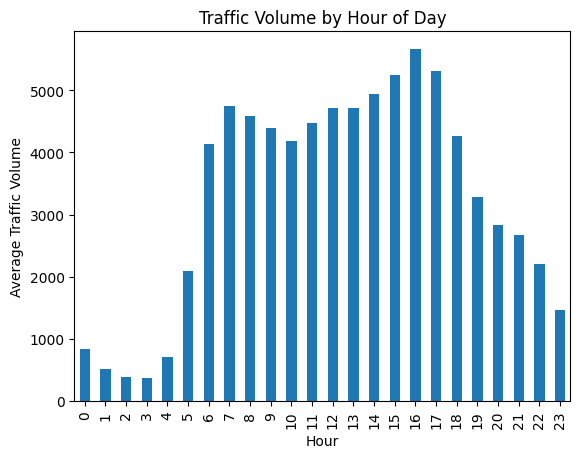

In [17]:
df.groupby('hour')['traffic_volume'].mean().plot(kind='bar', title='Traffic Volume by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Traffic Volume')
plt.show()

We can see that the traffic is very low during the night, between 0 and 5. but then at 6am, there is a huge change and the traffic is much much higher until it peaks at 16h (4pm). There is a slight decline at 10am but overall there is a great distinction between the day and the night. 

We also notice that the 2 local maximums are around the hours where people go to work and come back home.

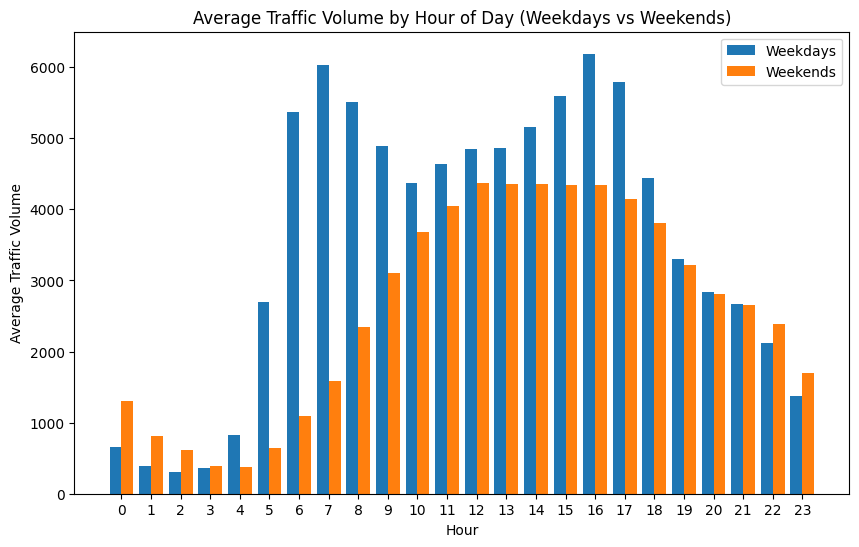

In [18]:
df_weekdays = df[df['is_weekend'] == 0]
df_weekends = df[df['is_weekend'] == 1]

traffic_weekdays = df_weekdays.groupby('hour')['traffic_volume'].mean()
traffic_weekends = df_weekends.groupby('hour')['traffic_volume'].mean()

plt.figure(figsize=(10, 6))
plt.bar(traffic_weekdays.index - 0.2, traffic_weekdays.values, width=0.4, label='Weekdays', align='center')
plt.bar(traffic_weekends.index + 0.2, traffic_weekends.values, width=0.4, label='Weekends', align='center')

plt.xlabel('Hour')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Hour of Day (Weekdays vs Weekends)')
plt.xticks(range(24))  # Afficher les heures de 0 à 23
plt.legend()

plt.show()

Then we wanted to compare the traffic during the week and the weekend. Overall, there is less traffic on the weekend than during the week, except at nighttime where there is more traffic on weekends. Obviously, people go out more at night dure their free days than when there is work. The peak during weekends also happens much later: around 12am.

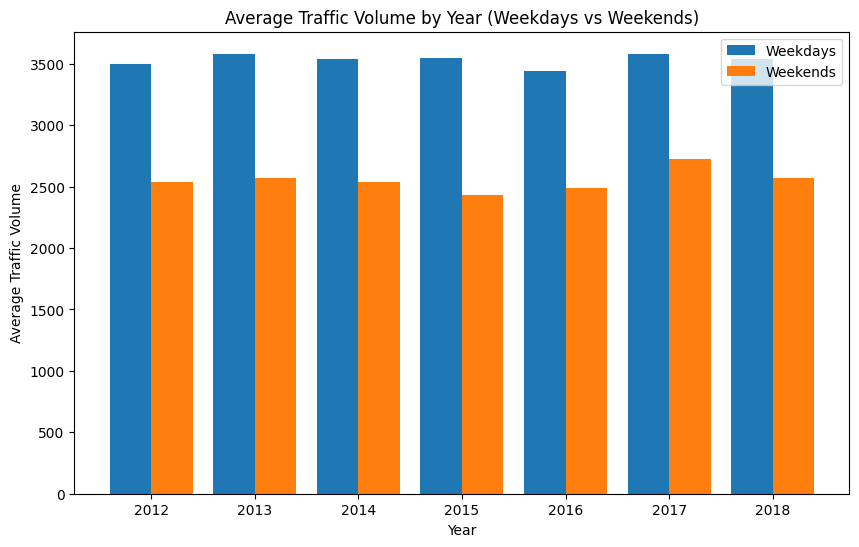

In [19]:
traffic_weekdays = df_weekdays.groupby('year')['traffic_volume'].mean()
traffic_weekends = df_weekends.groupby('year')['traffic_volume'].mean()

# Créer le graphique avec les deux séries
plt.figure(figsize=(10, 6))

# Barres pour les jours de semaine et week-ends, avec un léger décalage pour les différencier
plt.bar(traffic_weekdays.index - 0.2, traffic_weekdays.values, width=0.4, label='Weekdays', align='center')
plt.bar(traffic_weekends.index + 0.2, traffic_weekends.values, width=0.4, label='Weekends', align='center')

# Ajouter les labels et le titre
plt.xlabel('Year')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Year (Weekdays vs Weekends)')
plt.xticks(range(2012, 2019))  # Afficher les années de 2012 à 2018
plt.legend()

# Afficher le graphique
plt.show()

For every year, the traffic is much higher during the week than the weekend, this is consistent.

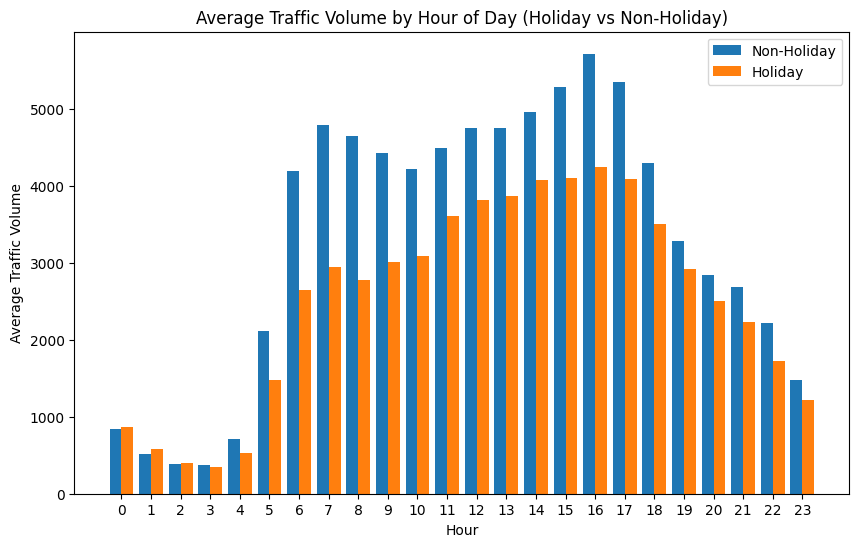

In [20]:
df_holiday = df[df['holiday'] == 1]
df_non_holiday = df[df['holiday'] == 0]

traffic_holiday = df_holiday.groupby('hour')['traffic_volume'].mean() if not df_holiday.empty else pd.Series()
traffic_non_holiday = df_non_holiday.groupby('hour')['traffic_volume'].mean()

plt.figure(figsize=(10, 6))

plt.bar(traffic_non_holiday.index - 0.2, traffic_non_holiday.values, width=0.4, label='Non-Holiday', align='center')
if not traffic_holiday.empty:
    plt.bar(traffic_holiday.index + 0.2, traffic_holiday.values, width=0.4, label='Holiday', align='center')

plt.xlabel('Hour')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Hour of Day (Holiday vs Non-Holiday)')
plt.xticks(range(24))
plt.legend()

plt.show()

Then, we wanted to study the difference in traffic for the holidays and non-holidays. We notice that the average traffic volume is generally higher on non-holidays compared to holidays throughout the day. The difference is particularly noticeable during morning rush hours around 6-9am and late afternoon 4-6pm, where non-holiday traffic peaks significantly more than holiday traffic.

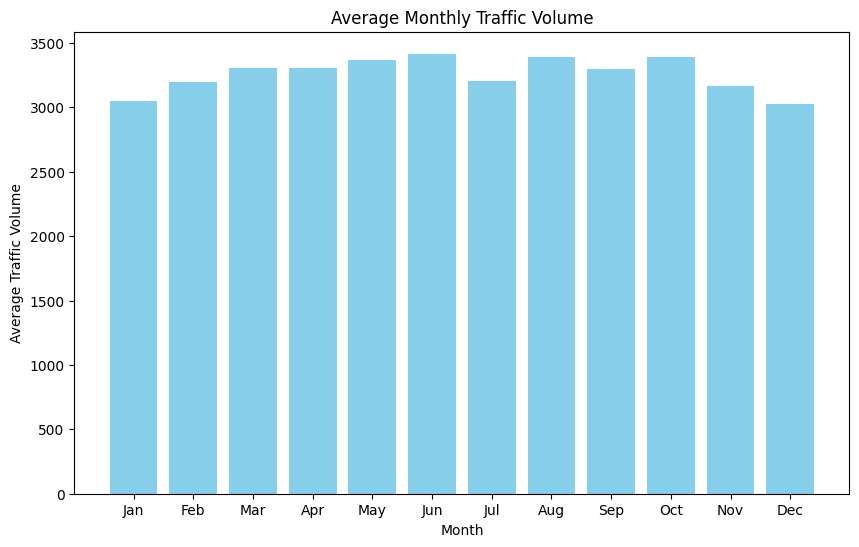

In [21]:
monthly_avg_traffic = df.groupby('month')['traffic_volume'].mean()

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_traffic.index, monthly_avg_traffic.values, color='skyblue')

# Ajouter les labels et le titre
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.title('Average Monthly Traffic Volume')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Afficher le graphique
plt.show()

The average monthly traffic volume remains consistent throughout the year, with slight peaks during summer (only july and august) and the smaller value being in December. The slight decrease for July could be due to travelling.

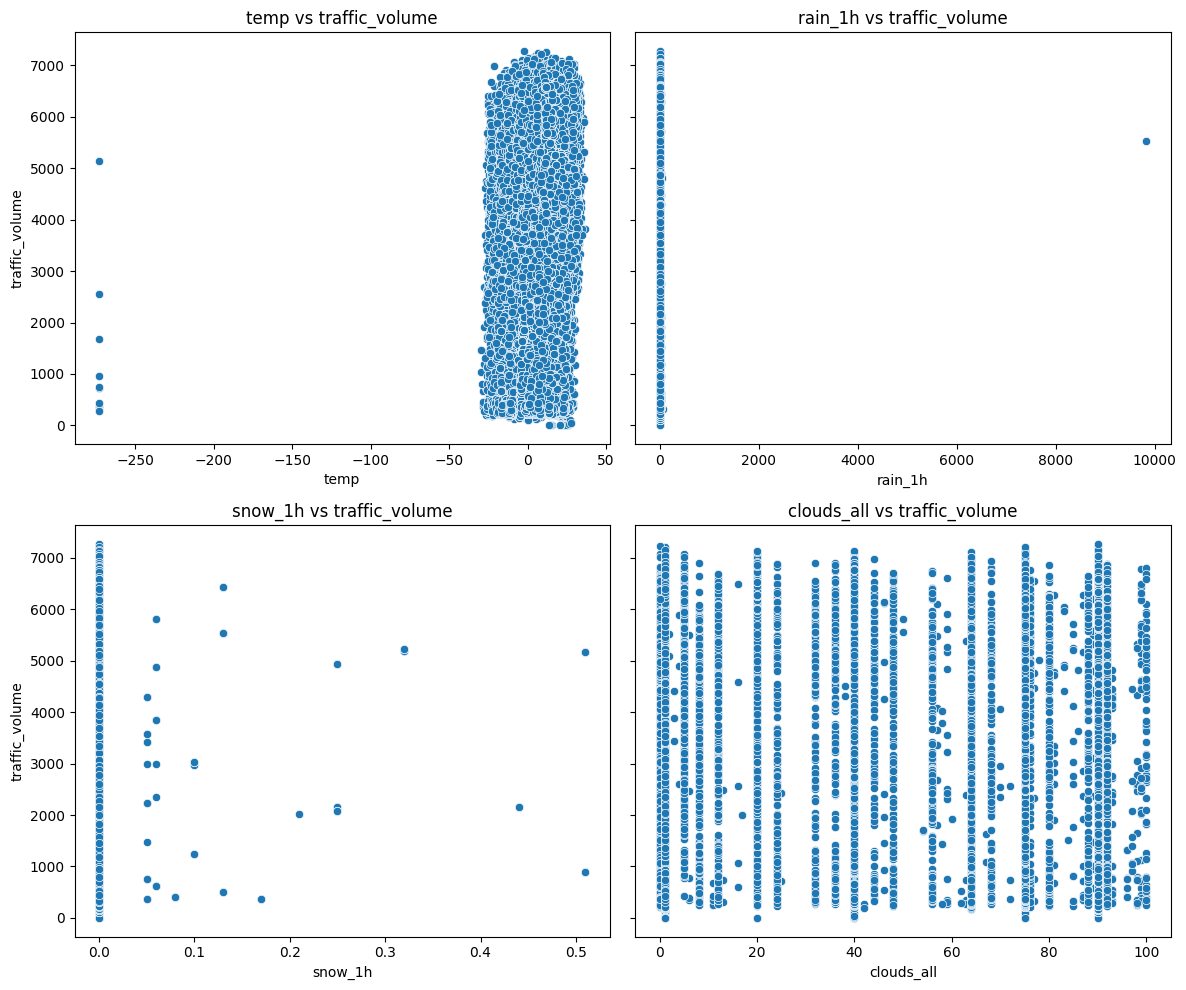

In [22]:
columns_to_plot = ['temp', 'rain_1h', 'snow_1h', 'clouds_all'] 
target_column = 'traffic_volume'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)  # Calculer la position (ligne, colonne)
    sns.scatterplot(data=df, x=column, y=target_column, ax=axes[row, col])
    axes[row, col].set_title(f'{column} vs {target_column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel(target_column)

plt.tight_layout()
plt.show()

These graphics show the relationship between weather variables and traffic volume. For temperature, traffic is concentrated in a normal range (around -10 to 30°C), with outliers at extreme negative temperatures, which might be data errors: first around -270°C which is definitely not normal but also towards -20/-30°C which is very low for an american city. For rain, traffic is mostly unaffected by rainfall, but there’s a significant outlier with extremely high rainfall (around 10,000 mm), likely an error as well. There are no trands for snow and cloud cover, though snow volume is typically minimal, around 0mm.

We need to take care of the outliers in the temp column. We can say that we remove every temperature that is below -20 °C. We can replace the value with the average of the temperature. 

In [23]:
print(min(df['temp']))
print(max(df['temp']))

-273.15
36.920000000000016


In [24]:
temp_mean = df['temp'][df['temp']>=-20].mean()
df['temp'] = df['temp'].apply(lambda x: temp_mean if x < -20 else x)

Let's now remove the outliers for the rain. We process the same way : we replace the outliers values with the mean of the others.

In [25]:
rain_mean = df['rain_1h'][df['rain_1h']<=1000].mean()
df['rain_1h'] = df['rain_1h'].apply(lambda x: rain_mean if x > 1000 else x)

Then we plot the figures again and see a real difference.

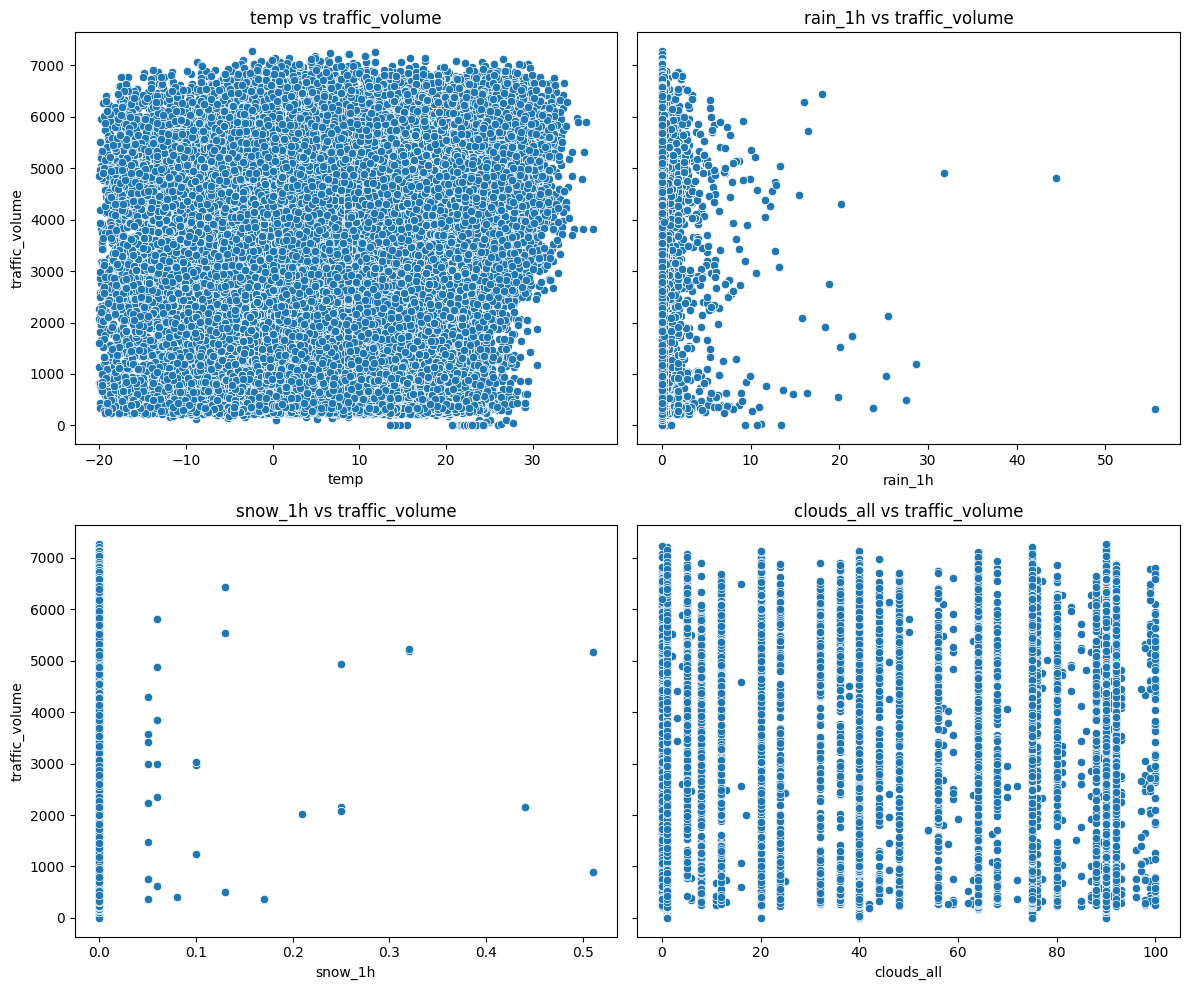

In [26]:
columns_to_plot = ['temp', 'rain_1h', 'snow_1h', 'clouds_all'] 
target_column = 'traffic_volume'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)  # Calculer la position (ligne, colonne)
    sns.scatterplot(data=df, x=column, y=target_column, ax=axes[row, col])
    axes[row, col].set_title(f'{column} vs {target_column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel(target_column)

plt.tight_layout()
plt.show()

We do have a better understanding of the repartition of the cloud and rain values without any outliers.

We transform the catogory columns so they become numerical colums.

On the one hand, we use OneHotEncoder to transform weather_main.

In [27]:
distinct_weather_main = df['weather_main'].unique()
print(distinct_weather_main)
print(df['weather_main'].value_counts())
one_hot_encoded_weather_main = pd.get_dummies(df['weather_main'], prefix='weather_main')
print(one_hot_encoded_weather_main)
df = pd.concat([df, one_hot_encoded_weather_main], axis=1)
df.drop('weather_main', axis=1, inplace=True)
df.head()

['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']
weather_main
Clouds          15158
Clear           13384
Mist             5949
Rain             5672
Snow             2875
Drizzle          1820
Haze             1360
Thunderstorm     1033
Fog               912
Smoke              20
Squall              4
Name: count, dtype: int64
       weather_main_Clear  weather_main_Clouds  weather_main_Drizzle  \
0                   False                 True                 False   
1                   False                 True                 False   
2                   False                 True                 False   
3                   False                 True                 False   
4                   False                 True                 False   
...                   ...                  ...                   ...   
48199               False                 True                 False   
48200               False                 True 

holiday   temp  rain_1h  snow_1h  clouds_all  weather_description  \
0        0  15.13      0.0      0.0          40                    8   
1        0  16.21      0.0      0.0          75                    7   
2        0  16.43      0.0      0.0          90                    6   
3        0  16.98      0.0      0.0          90                    6   
4        0  17.99      0.0      0.0          75                    7   

   traffic_volume  hour  year  month  ...  weather_main_Clouds  \
0            5545     9  2012     10  ...                 True   
1            4516    10  2012     10  ...                 True   
2            4767    11  2012     10  ...                 True   
3            5026    12  2012     10  ...                 True   
4            4918    13  2012     10  ...                 True   

   weather_main_Drizzle weather_main_Fog weather_main_Haze  weather_main_Mist  \
0                 False            False             False              False   
1                 False            False             False              False   
2                 False            False             False              False   
3                 False            False             False              False   
4                 False            False             False              False   

   weather_main_Rain  weather_main_Smoke  weather_main_Snow  \
0              False               False              False   
1              False               False              False   
2              False               False              False   
3              False               False              False   
4              False               False              False   

   weather_main_Squall  weather_main_Thunderstorm  
0                False                      False  
1                False                      False  
2                False                      False  
3                False                      False  
4                False                      False  

[5 rows x 25 columns]

On the other hand, we use LabelEncoder to transform season and part_of_the_day.

In [28]:
label_encoder = LabelEncoder()
df['season'] = label_encoder.fit_transform(df['season'])
df['part_of_the_day']=label_encoder.fit_transform(df['part_of_the_day'])

### Correlation Matrix

Now that all our columns are numerical, we can plot the correlation matrix to view the correlations between the columns.

                            holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday                    1.000000 -0.029896 -0.012253 -0.004726    0.014384   
temp                      -0.029896  1.000000  0.089172 -0.023324   -0.157707   
rain_1h                   -0.012253  0.089172  1.000000  0.001523    0.081510   
snow_1h                   -0.004726 -0.023324  0.001523  1.000000    0.027934   
clouds_all                 0.014384 -0.157707  0.081510  0.027934    1.000000   
weather_description       -0.005352  0.070460 -0.179981 -0.026292   -0.738308   
traffic_volume            -0.062731  0.121709 -0.022342  0.000736    0.067138   
hour                       0.006364  0.103102 -0.011344  0.009852    0.054522   
year                       0.001205  0.135271 -0.032599 -0.003514   -0.072855   
month                      0.027753  0.209361  0.028432  0.020422   -0.009118   
day                       -0.161842 -0.003869 -0.006398 -0.014929   -0.039816   
is_weekend                -0

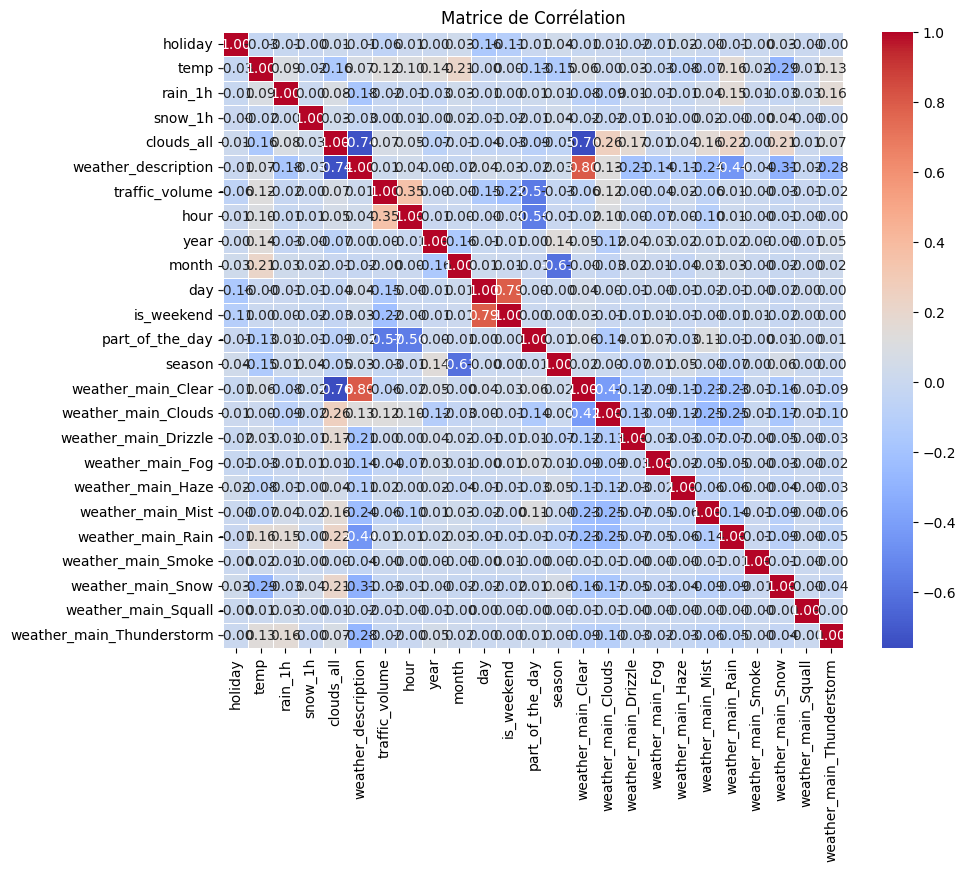

In [29]:
corr_matrix = df.corr()
print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

Because the most important is the correlation with our target variable, we now plot the correlations to the traffic_volume column.

C:\Users\lorra\AppData\Local\Temp\ipykernel_14636\1614615849.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_volume.values, y=corr_volume.index, palette="viridis")


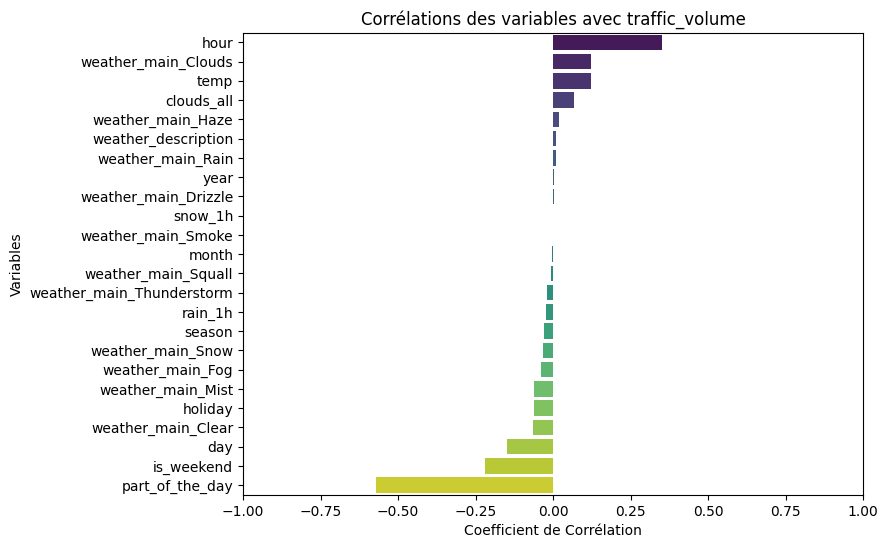

In [30]:
corr_volume = corr_matrix["traffic_volume"].sort_values(ascending=False).drop("traffic_volume")

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_volume.values, y=corr_volume.index, palette="viridis")
plt.title("Corrélations des variables avec traffic_volume")
plt.xlim(-1, 1)
plt.xlabel("Coefficient de Corrélation")
plt.ylabel("Variables")
plt.show()

The "hour" column shows the strongest positive correlation, indicating higher traffic at specific times. On the negative side, "part_of_the_day" and "is_weekend" have important negative correlations, suggesting lower traffic during certain day parts and on weekends. Temperature ("temp") also positively correlates with traffic volume. Weather conditions like clouds have a moderate impact on traffic volume, while others like fog and clear weather show very small correlation.

## Train-test on different models

First we take all the columns that will later need to be standardized. Because now all of our columns are numerical but only the columns below are actual real continous values that are relevant to standardize.

In [31]:
numeric_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']

We create a new dataset with all of the columns but one: our target column, the one we wnat to predict: traffic_volume.

Then, we use train_test_split to separate our new data set into 2 parts: one we are going to train our models on and the other to test our predictions by comparing it the to result of our models. This will help us observe the accuracy of the model and determine its quality.

In [32]:
X=df.drop('traffic_volume', axis=1)
Y=df['traffic_volume']

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=42)

We create a pipeline through which we will train our models: First we will use ColumnTransformer to standardize the columns above and then we specify the model we want to use.

In [33]:
def create_pipeline(model):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols)
        ],
        remainder='passthrough'
    )
    my_pipeline = SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return my_pipeline

We are going to train and test several basic models now. To observe the model's performance, we will calculate the R² score, which indicates if the model has good predictions if it is close to 1 or bad predictions whan the score is closer to 0. We will also evaluate the Mean Squared Error (MSE), which quantifies the average squared difference between the predicted and actual values, giving us insight into the model's prediction accuracy. Additionally, we will compare the models' performance on both the training and test datasets to assess for any signs of overfitting or underfitting, ensuring that our chosen model generalizes well to new, unseen data.

Visualizing underfitting and overfitting is crucial for understanding model performance. Underfitting occurs when a model is too simple to capture the data's patterns, leading to poor performance on both training and test data. However, overfitting happens when a model is too complex, performing well on training data but poorly on test data. By plotting learning curves and comparing training and validation errors, we can identify these issues and ensure better generalization and more reliable predictions.

We will also use cross-validation to envaluate our model. Cross-validation helps us better evaluate our model by splitting the data into multiple parts and training the model on different combinations of these parts. This way, every piece of data gets a chance to be in both the training and testing sets. By doing this, we get a more reliable measure of how well our model performs and can avoid overfitting. Here, k-fold cross-validation is used, where the data is divided into k subsets, and the model is trained and tested k times, each time with a different subset as the test set.

In [34]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error')

    train_errors = -train_scores.mean(axis=1)
    val_errors = -val_scores.mean(axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_errors, label="Training Error")
    plt.plot(train_sizes, val_errors, label="Validation Error")
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Learning Curve for the Model {model.named_steps["model"]}')
    plt.legend()
    plt.show()

## Stage 1

In [35]:
stage_1_models = {
    'RandomForestRegressor': RandomForestRegressor(max_depth=None,max_features='sqrt',min_samples_split=2,n_estimators=200),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators= 200,learning_rate= 0.2,max_depth= 5,subsample= 0.8),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=0.1),
    'KNeighborsRegressor': KNeighborsRegressor(algorithm='auto', n_neighbors=5, weights='uniform')
}

In our traffic volume forecasting project, we used different models to test which one would fit better.

RandomForestRegressor: This ensemble method combines multiple decision trees to minimize overfitting and handle complex data interactions, making it ideal for capturing non-linear relationships in traffic patterns.

GradientBoostingRegressor: This boosting algorithm builds trees sequentially, with each one correcting the errors of the previous one. It effectively captures difficult patterns and is robust against outliers.

LinearRegression: A simple but powerful model that assumes a linear relationship between the features and the target variable. It acts as a baseline and performs well when the relationships in the data are somewhat linear.

Ridge: A regularized form of linear regression that adds a penalty to the size of the coefficients, helping to avoid overfitting. It’s particularly useful when features are highly correlated.

KNeighborsRegressor: This algorithm predicts traffic volume by averaging the values of the k-nearest neighbors. It's effective for capturing local patterns and can handle non-linear relationships.


### Hyperparameters finetuning

We used GridSearch to find the best hyperparameters of each model. We ran them once but then wrote them directly in the definition of the model because it takes a lot of time to run. Here are all of our GridSearch:

RandomForest:

In [36]:
# model=RandomForestRegressor(n_estimators=100, random_state=42)
# pipeline = create_pipeline(model)

# param_grid = {
#     'model__n_estimators': [100, 200],  # Number of trees
#     'model__max_depth': [None, 10],     # Maximum depth of trees
#     'model__min_samples_split': [2, 10],  # Minimum samples required to split
#     'model__max_features': ['log2', 'sqrt'],  # Number of features to consider
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',  # Scoring based on negative MSE
#     n_jobs=-1,  # Use all cores for faster computation
#     verbose=1  # Show progress
# )

# # Perform Grid Search with the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters found by GridSearchCV
# print(f"Best parameters: {grid_search.best_params_}")


# # after grid search : 


# best_randomforest=RandomForestRegressor(
#     max_depth=None,
#     max_features='sqrt',
#     min_samples_split=2,
#     n_estimators=200
# )

Gradient Boosting:

In [37]:
# model2= GradientBoostingRegressor(n_estimators=100, random_state=42)
# pipeline2 = create_pipeline(model2)

# param_grid = {
#     'model__n_estimators': [50, 100, 200],        # Nombre d'arbres
#     'model__learning_rate': [0.01, 0.1, 0.2],    # Taux d'apprentissage
#     'model__max_depth': [3, 4, 5],               # Profondeur des arbres
#     'model__subsample': [0.8, 1.0],              # Sous-échantillonnage
# }

# grid_search = GridSearchCV(
#     estimator=pipeline2,
#     param_grid=param_grid,
#     cv=5,  # Validation croisée à 5 plis
#     scoring='neg_mean_squared_error',  # Utiliser MSE comme critère d’évaluation
#     n_jobs=-1,  # Utiliser tous les cœurs disponibles pour accélérer
#     verbose=1   # Afficher les progrès
# )

# # Effectuer la recherche sur les hyperparamètres
# grid_search.fit(X_train, y_train)

# # Meilleurs hyperparamètres
# print(f"Best parameters: {grid_search.best_params_}")

# after grid search :

# best_gradientboost=GradientBoostingRegressor(
#     n_estimators= 200,       
#     learning_rate= 0.2,    
#     max_depth= 5,             
#     subsample= 0.8,             
# )

Linear Regression doesn't have any hyperparameters.

Ridge:

In [38]:
# model4= Ridge()
# pipeline4=create_pipeline(model4)

# param_grid = {
#     'model__alpha': [0.1, 1, 10, 100, 1000]  # valeurs différentes pour alpha
# }

# grid_search = GridSearchCV(
#     estimator=pipeline4,
#     param_grid=param_grid,
#     cv=5,  # Validation croisée à 5 plis
#     scoring='neg_mean_squared_error',  # Utiliser MSE comme critère d’évaluation
# )


# # Effectuer la recherche sur les hyperparamètres
# grid_search.fit(X_train, y_train)

# # Meilleurs hyperparamètres
# print(f"Best parameters: {grid_search.best_params_}")

# after grid search :

# best_ridge=Ridge(
#     alpha=0.1
# )

KNeighbors:

In [39]:
# model5=KNeighborsRegressor()
# pipeline5=create_pipeline(model5)

# param_grid = {
#     'model__n_neighbors': [3, 5],  # Number of neighbors to use
#     'model__weights': ['uniform'],  # Weight function for prediction
#     'model__algorithm': ['auto'],  # Algorithm used to compute nearest neighbors
# }

# grid_search = GridSearchCV(
#     estimator=pipeline5,
#     param_grid=param_grid,
#     cv=5,  # Validation croisée à 5 plis
#     scoring='neg_mean_squared_error',  # Utiliser MSE comme critère d’évaluation
# )


# # Effectuer la recherche sur les hyperparamètres
# grid_search.fit(X_train, y_train)

# # Meilleurs hyperparamètres
# print(f"Best parameters: {grid_search.best_params_}")

# after grid search :

# best_kneighbors=KNeighborsRegressor(
#     algorithm='auto',
#     n_neighbors=5,
#     weights='uniform'
# )

Training model RandomForestRegressor
Cross Validation score 133742.3507199404
RandomForestRegressor : MSE = 126551.2169921107, R2 = 0.9683457806239455


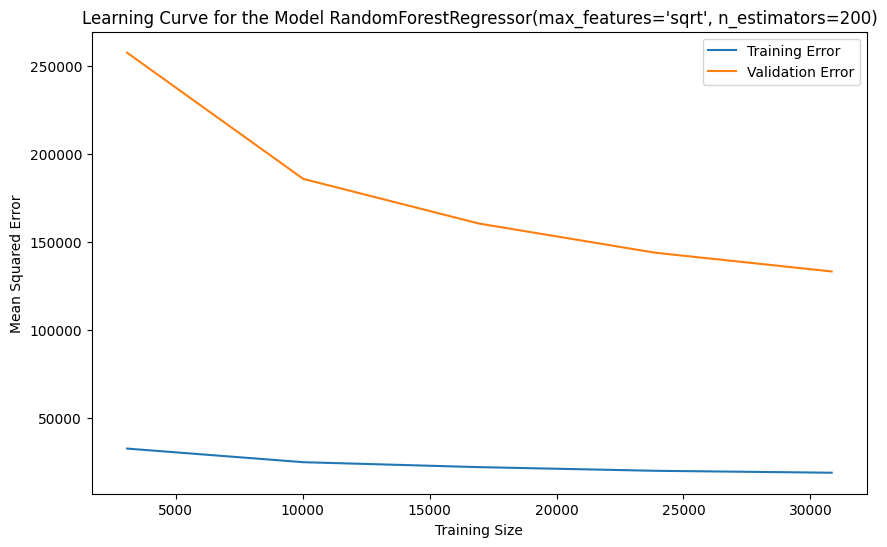

Training model GradientBoostingRegressor
Cross Validation score 121626.61761492588
GradientBoostingRegressor : MSE = 119337.48797326433, R2 = 0.9701501485811198


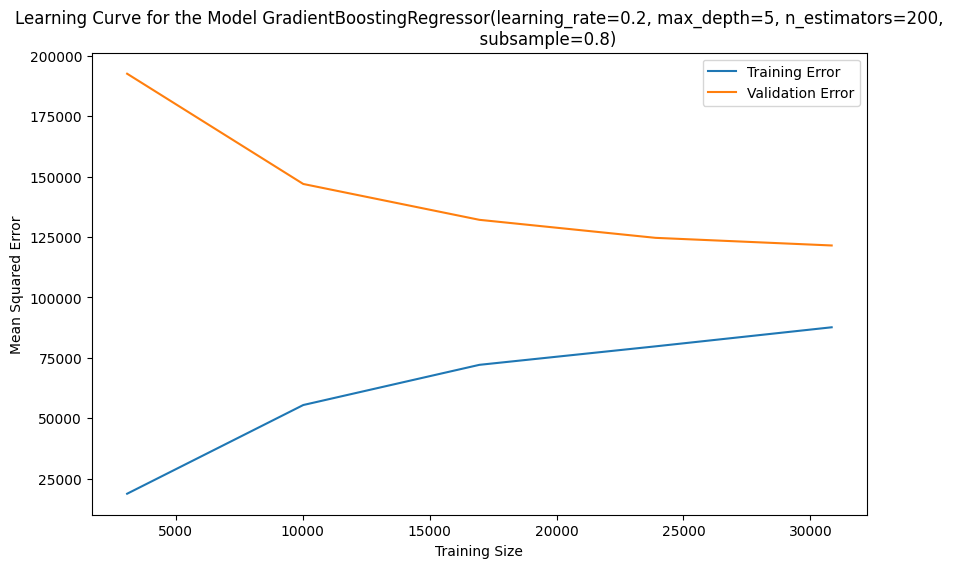

Training model LinearRegression
Cross Validation score 2399885.9278667625
LinearRegression : MSE = 2445302.3147111866, R2 = 0.38835723788047627


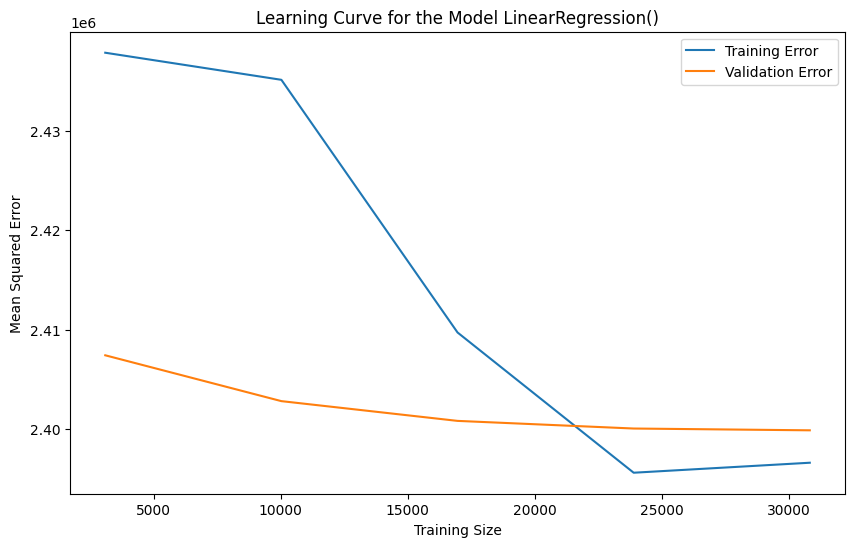

Training model Ridge
Cross Validation score 2399885.4006909365
Ridge : MSE = 2445299.0143651413, R2 = 0.38835806339507994


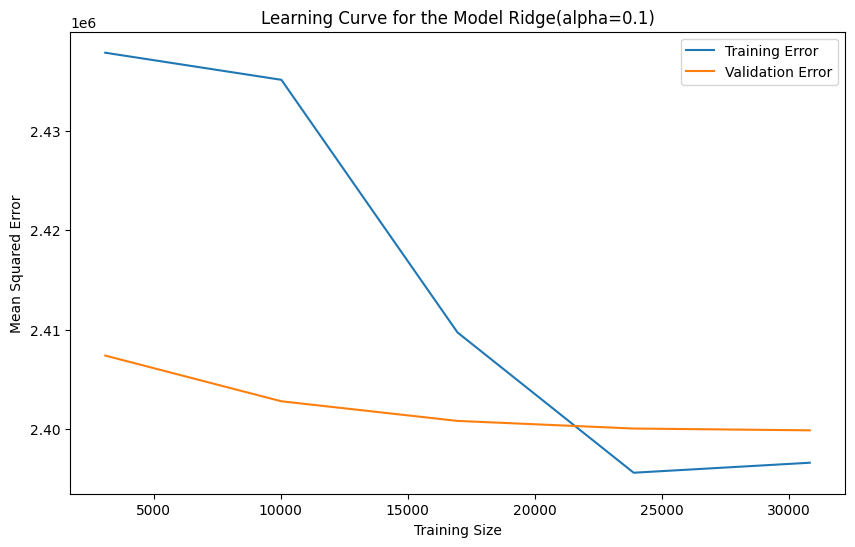

Training model KNeighborsRegressor
Cross Validation score 261425.5381031964
KNeighborsRegressor : MSE = 228342.28346129903, R2 = 0.9428848105509425


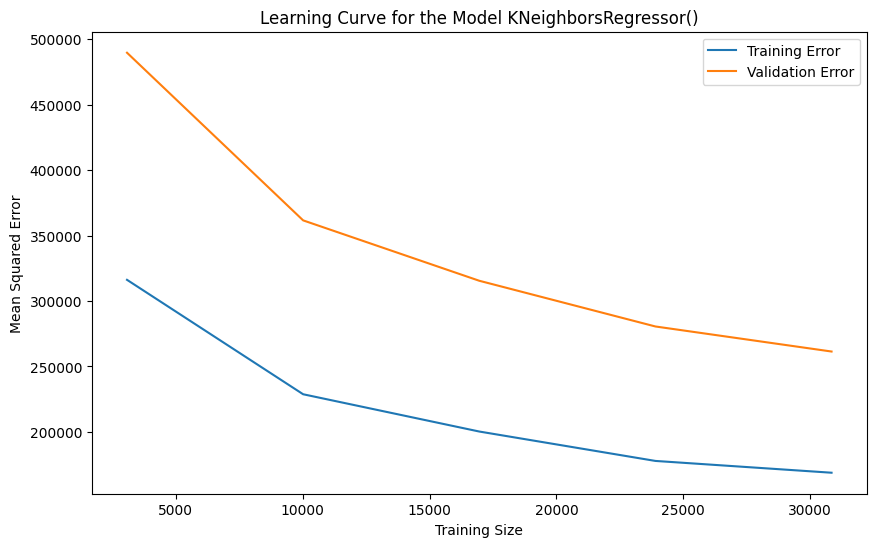

In [40]:
models_scores = {}
for model_name, model in stage_1_models.items():
    print(f"Training model {model_name}")
    pipeline = create_pipeline(model)
    # cross Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross Validation score {-scores.mean()}")
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} : MSE = {mse}, R2 = {r2}")
    models_scores[model_name] = { 'mse': mse, 'r2': r2 }
    plot_learning_curve(pipeline, X_train, y_train)

### Comparison of the MSE and R2 score between models

To evaluate the performance of our models, we will compare their Mean Squared Error (MSE) values and their R2 score. By analyzing the MSE and R2 score for each model, we can identify which models offer the best fit for our data. This comparison is crucial for selecting the most reliable model for accurate traffic forecasting.

{'RandomForestRegressor': {'mse': 127354.99117645794, 'r2': 0.9681447328192316}, 'GradientBoostingRegressor': {'mse': 117955.06384958, 'r2': 0.9704959339281274}, 'LinearRegression': {'mse': 2445271.5792276077, 'r2': 0.38836492573811177}, 'Ridge': {'mse': 2445268.2865429046, 'r2': 0.3883657493363861}, 'KNeighborsRegressor': {'mse': 227094.39236771117, 'r2': 0.9431969451899663}}


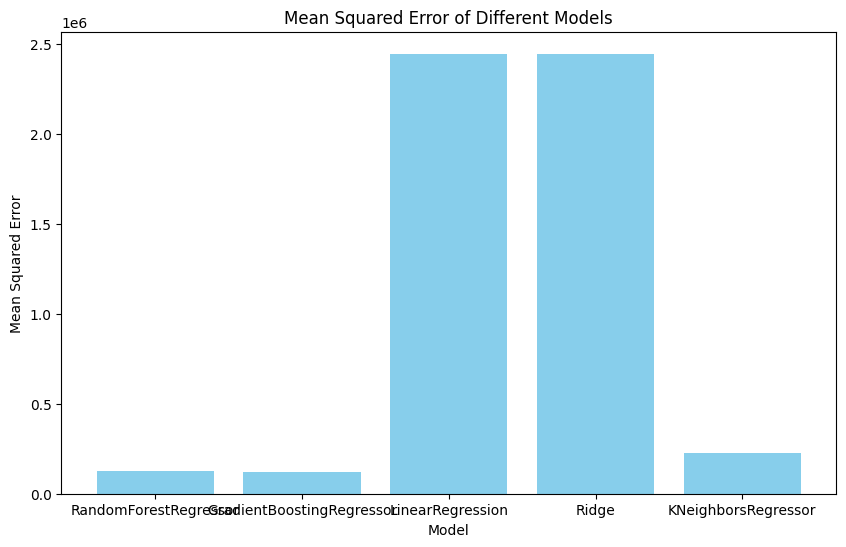

In [ ]:
print(models_scores)

plt.figure(figsize=(10, 6))
plt.bar(models_scores.keys(), [model['mse'] for model in models_scores.values()], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Different Models')
plt.show()

{'RandomForestRegressor': {'mse': 127354.99117645794, 'r2': 0.9681447328192316}, 'GradientBoostingRegressor': {'mse': 117955.06384958, 'r2': 0.9704959339281274}, 'LinearRegression': {'mse': 2445271.5792276077, 'r2': 0.38836492573811177}, 'Ridge': {'mse': 2445268.2865429046, 'r2': 0.3883657493363861}, 'KNeighborsRegressor': {'mse': 227094.39236771117, 'r2': 0.9431969451899663}}


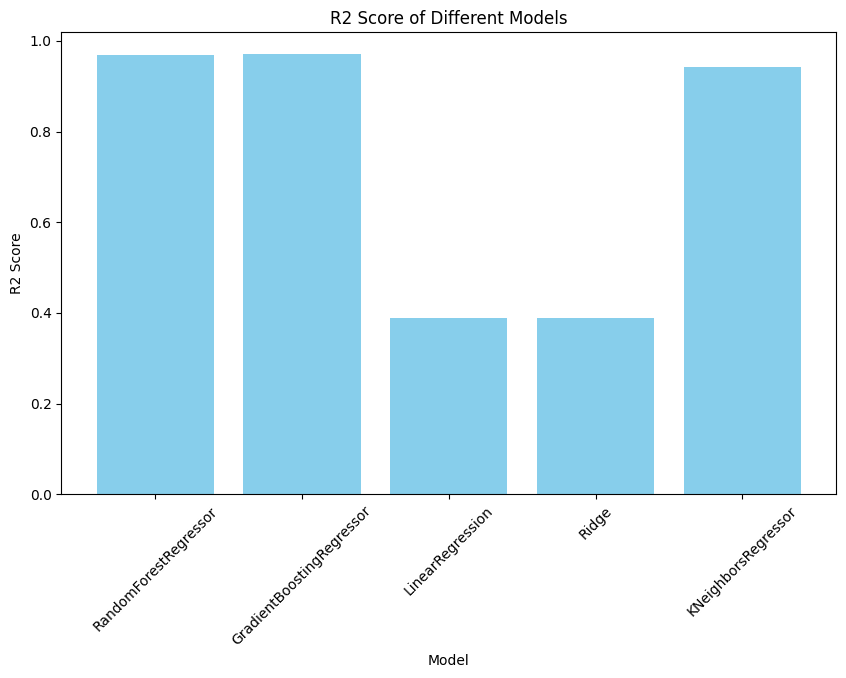

In [ ]:
print(models_scores)

plt.figure(figsize=(10, 6))
plt.bar(models_scores.keys(), [model['r2'] for model in models_scores.values()], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('R2 Score of Different Models')
plt.show()

#### Stage 1 Model Performance Summary

##### Model Performance Metrics

| Model                     | MSE          | R²           |
|---------------------------|--------------|--------------|
| RandomForestRegressor     | 127 354.99   | 0.968        |
| GradientBoostingRegressor | 117 955.06   | 0.970        |
| LinearRegression          | 2 445 271.58 | 0.388        |
| Ridge                      | 2 445 268.29 | 0.388        |
| KNeighborsRegressor        | 227 094.39   | 0.943        |

##### Interpretation

- **Best Performing Model**: The **GradientBoostingRegressor** is the best performing model with the highest R² score (0.970) and the lowest MSE (117,955.06), indicating the most accurate predictions.
- **Worst Performing Models**: The **LinearRegression** and **Ridge** models performed the worst with very low R² scores (0.388) and high MSE, indicating poor explanatory power and inaccurate predictions.
- **Middle Ground**: The **RandomForestRegressor** and **KNeighborsRegressor** performed well but were outperformed by the GradientBoostingRegressor. They still provided reasonably accurate predictions with high R² scores and moderate MSE.

##### Conclusion

These results suggest that ensemble methods like **GradientBoostingRegressor** and **RandomForestRegressor** are more effective for this particular dataset compared to linear models and k-nearest neighbors. The GradientBoostingRegressor stands out as the top performer, making it the preferred choice for this regression task.


# Stage 2

To calculate the hyperparameters, all the calculations are after

In [ ]:
stage_2_models = {
    'AdaBoostRegressor': AdaBoostRegressor(learning_rate=0.9, n_estimators=50),
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.1, max_depth=10, n_estimators= 400, subsample= 0.8),
    'XGBRegressor': XGBRegressor(learning_rate = 0.8, max_depth = 5, n_estimators = 300),
    'LGBMRegressor': LGBMRegressor(n_estimators=300, learning_rate=0.2, max_depth=5, subsample=0.8, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(learning_rate= 0.09932957599044291, depth= 10, subsample= 0.4610743554231213, colsample_bylevel= 0.7558403488058412, min_data_in_leaf= 100, verbose=0),
    'RandomForestRegressor_Bagging': BaggingRegressor(estimator=RandomForestRegressor(n_estimators = 100, max_depth = 30, min_samples_split = 6, max_features = 'log2'), n_estimators = 20, max_samples= 0.6627269114211244, max_features= 0.9661119481747255, random_state=42),
    'RandomForestRegressor_Boosting': AdaBoostRegressor(estimator=RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_split=2, n_estimators=200), n_estimators=50, learning_rate=0.1)
}

Training model AdaBoostRegressor
CV score 565669.6354087356
(569084.7658219978, 0.8576549917965377)
AdaBoostRegressor : MSE = 569084.7658219978, R2 = 0.8576549917965377


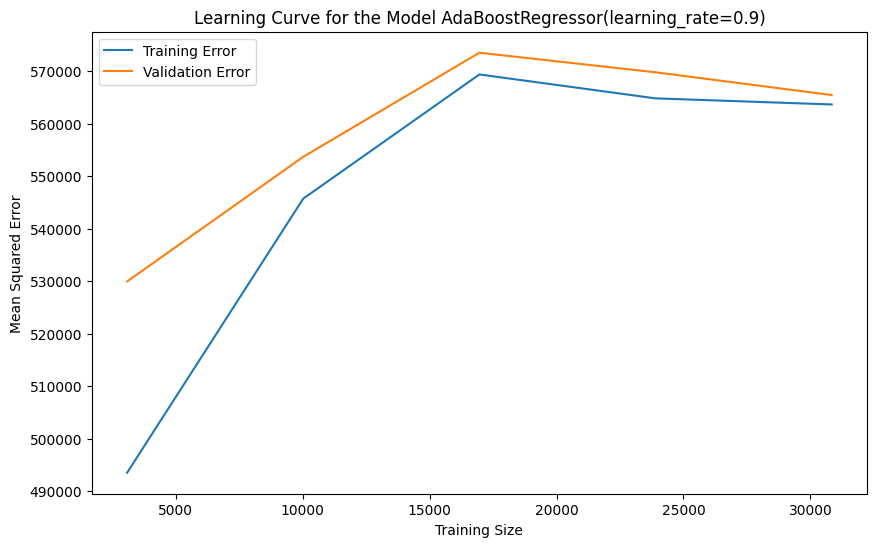

Training model GradientBoostingRegressor
CV score 96612.66907151045
(89337.01546258794, 0.9776541581103007)
GradientBoostingRegressor : MSE = 89337.01546258794, R2 = 0.9776541581103007


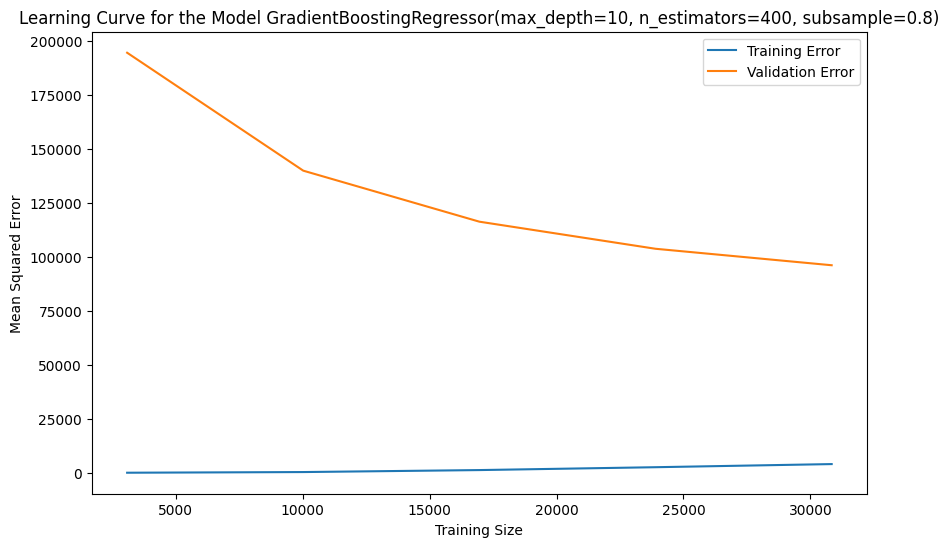

Training model XGBRegressor
CV score 123675.22059189838
(114806.7652980403, 0.9712834169360385)
XGBRegressor : MSE = 114806.7652980403, R2 = 0.9712834169360385


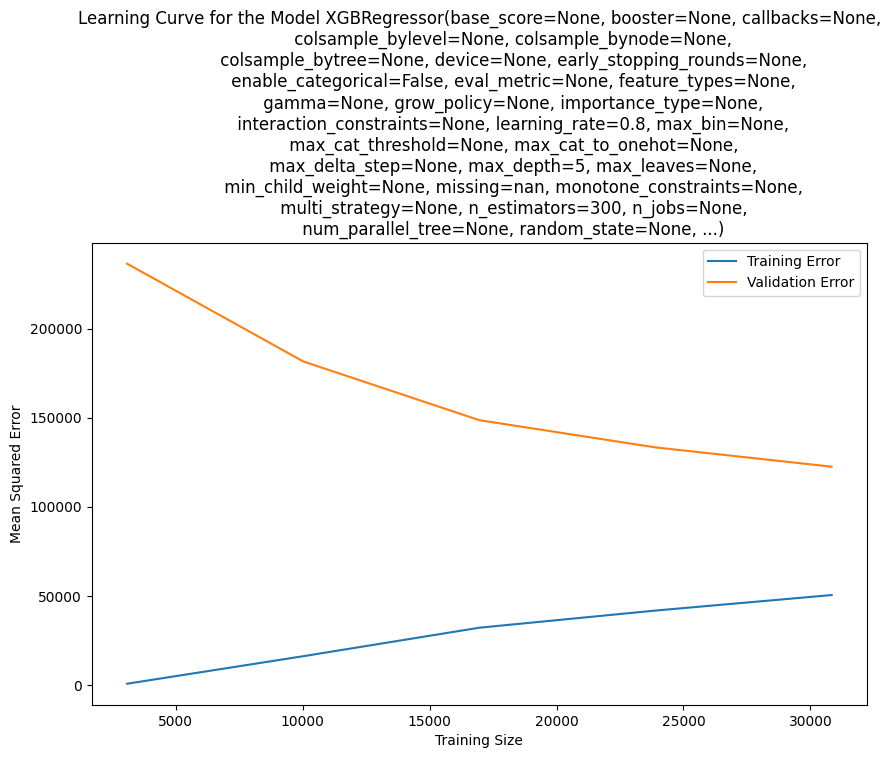

Training model LGBMRegressor


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

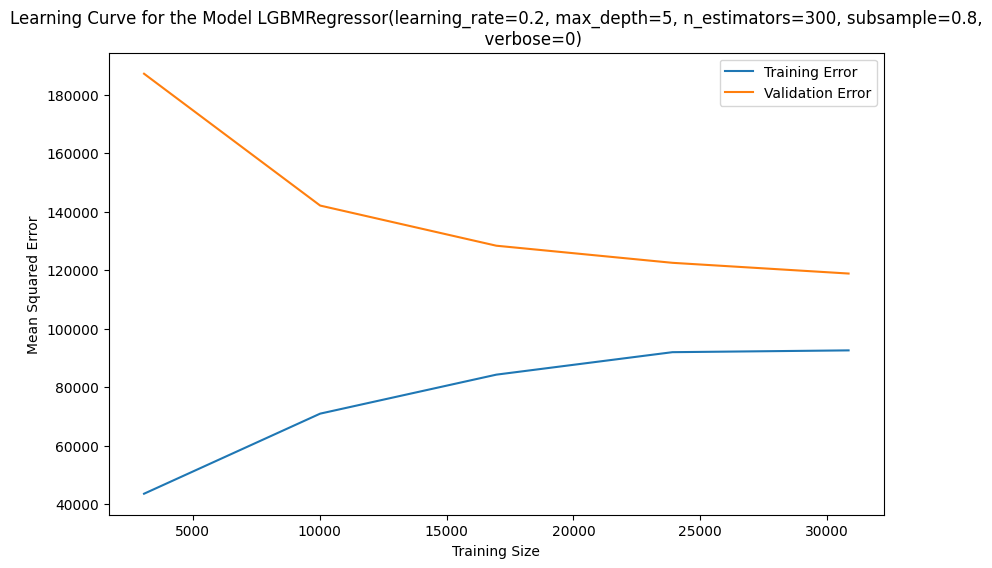

Training model CatBoostRegressor
0:	learn: 1810.8273665	total: 159ms	remaining: 2m 38s
1:	learn: 1659.2624441	total: 174ms	remaining: 1m 27s
2:	learn: 1518.7975325	total: 189ms	remaining: 1m 2s
3:	learn: 1392.1781245	total: 204ms	remaining: 50.9s
4:	learn: 1285.2494914	total: 209ms	remaining: 41.5s
5:	learn: 1187.6862249	total: 224ms	remaining: 37.1s
6:	learn: 1098.1571863	total: 239ms	remaining: 33.9s
7:	learn: 1022.9319337	total: 255ms	remaining: 31.6s
8:	learn: 952.1780565	total: 271ms	remaining: 29.8s
9:	learn: 894.6422773	total: 287ms	remaining: 28.4s
10:	learn: 839.2495427	total: 303ms	remaining: 27.2s
11:	learn: 788.0737696	total: 320ms	remaining: 26.3s
12:	learn: 745.2992867	total: 335ms	remaining: 25.4s
13:	learn: 710.5100301	total: 350ms	remaining: 24.6s
14:	learn: 677.0139236	total: 366ms	remaining: 24.1s
15:	learn: 648.6901115	total: 382ms	remaining: 23.5s
16:	learn: 623.7083897	total: 398ms	remaining: 23s
17:	learn: 601.8581131	total: 413ms	remaining: 22.5s
18:	learn: 583.

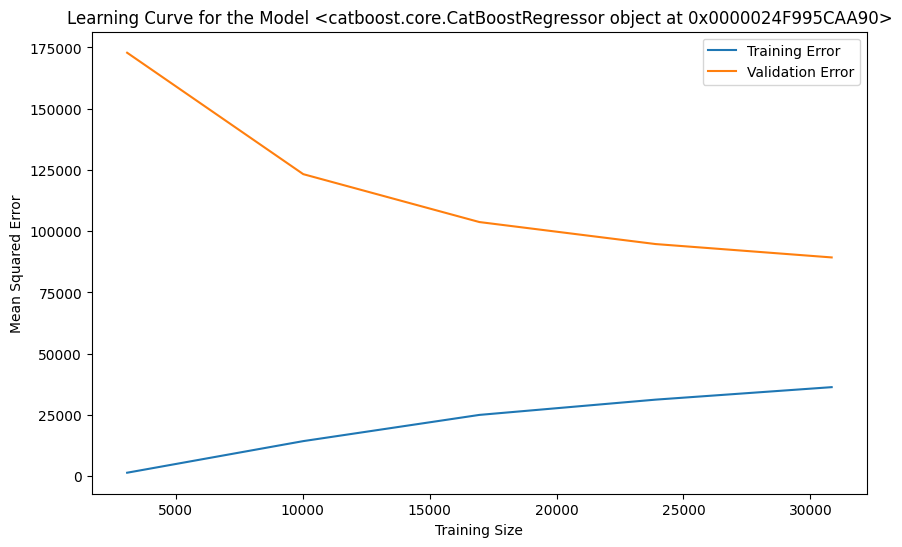

Training model RandomForestRegressor_Bagging
CV score 174260.2588858587
(164738.38746442125, 0.9587940346967873)
RandomForestRegressor_Bagging : MSE = 164738.38746442125, R2 = 0.9587940346967873


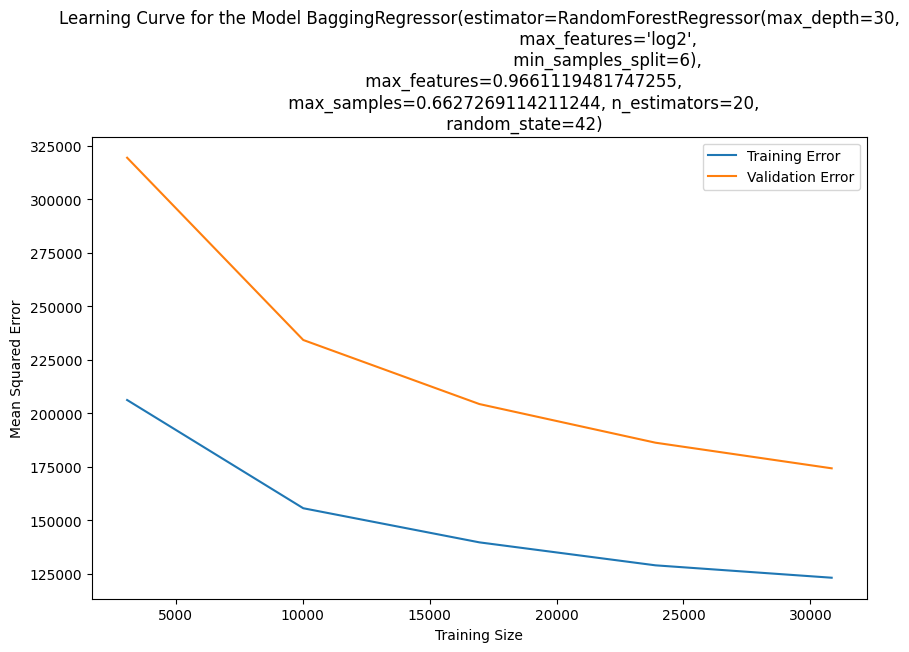

Training model RandomForestRegressor_Boosting
CV score 129740.21539011606
(125312.05046446172, 0.9686557329898094)
RandomForestRegressor_Boosting : MSE = 125312.05046446172, R2 = 0.9686557329898094


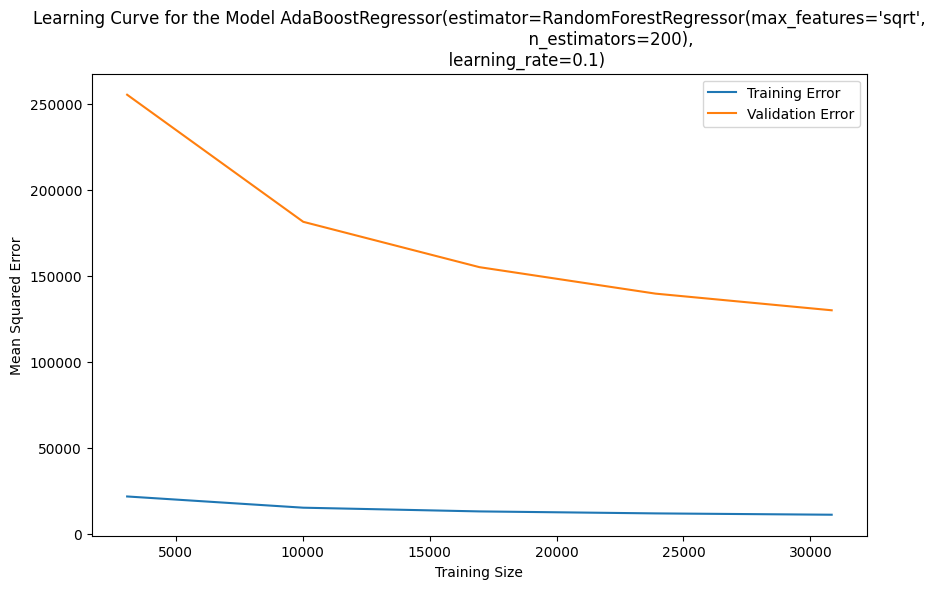

In [42]:
models_scores = {}
for model_name, model in stage_2_models.items():
    print(f"Training model {model_name}")
    pipeline = create_pipeline(model)
    # cross Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"CV score {-scores.mean()}")
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print((mse, r2))
    print(f"{model_name} : MSE = {mse}, R2 = {r2}")
    models_scores[model_name] = { 'mse': mse, 'r2': r2 }
    plot_learning_curve(pipeline, X_train, y_train)

{'AdaBoostRegressor': {'mse': 569084.7658219978, 'r2': 0.8576549917965377}, 'GradientBoostingRegressor': {'mse': 89337.01546258794, 'r2': 0.9776541581103007}, 'XGBRegressor': {'mse': 114806.7652980403, 'r2': 0.9712834169360385}, 'LGBMRegressor': {'mse': 114087.88105025409, 'r2': 0.9714632312454246}, 'CatBoostRegressor': {'mse': 83835.91183377232, 'r2': 0.9790301475730318}, 'RandomForestRegressor_Bagging': {'mse': 164738.38746442125, 'r2': 0.9587940346967873}, 'RandomForestRegressor_Boosting': {'mse': 125312.05046446172, 'r2': 0.9686557329898094}}


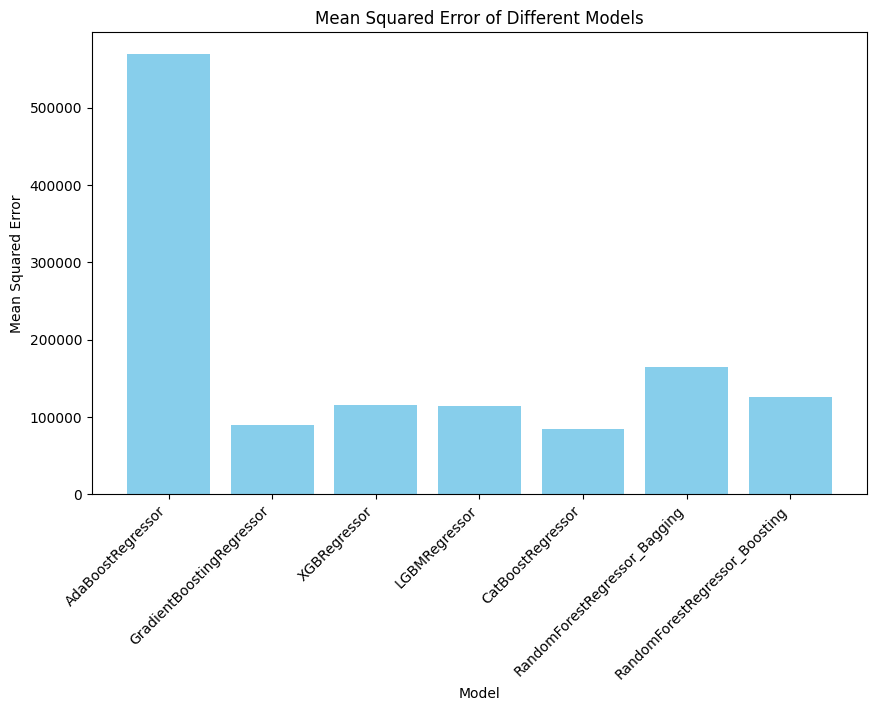

In [47]:
print(models_scores)

plt.figure(figsize=(10, 6))
plt.bar(models_scores.keys(), [model['mse'] for model in models_scores.values()], color='skyblue')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Different Models')
plt.show()

{'AdaBoostRegressor': {'mse': 569084.7658219978, 'r2': 0.8576549917965377}, 'GradientBoostingRegressor': {'mse': 89337.01546258794, 'r2': 0.9776541581103007}, 'XGBRegressor': {'mse': 114806.7652980403, 'r2': 0.9712834169360385}, 'LGBMRegressor': {'mse': 114087.88105025409, 'r2': 0.9714632312454246}, 'CatBoostRegressor': {'mse': 83835.91183377232, 'r2': 0.9790301475730318}, 'RandomForestRegressor_Bagging': {'mse': 164738.38746442125, 'r2': 0.9587940346967873}, 'RandomForestRegressor_Boosting': {'mse': 125312.05046446172, 'r2': 0.9686557329898094}}


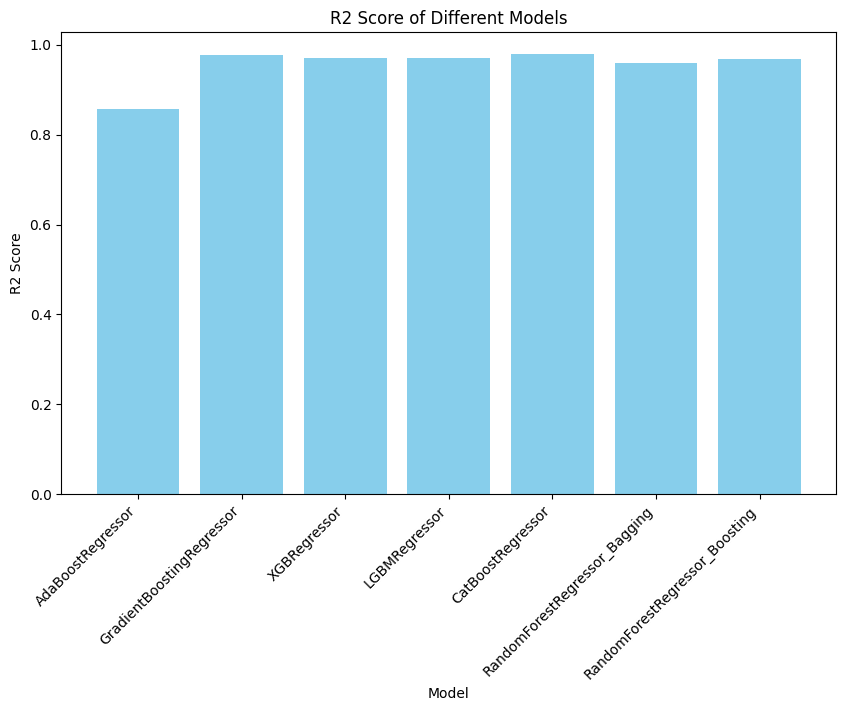

In [48]:
print(models_scores)

plt.figure(figsize=(10, 6))
plt.bar(models_scores.keys(), [model['r2'] for model in models_scores.values()], color='skyblue')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('R2 Score')
plt.title('R2 Score of Different Models')
plt.show()

#### Stage 2 Model Performance Summary

##### Model Performance Metrics

| Model                         | MSE          | R²           |
|-------------------------------|--------------|--------------|
| AdaBoostRegressor             | 569,084.77   | 0.858        |
| GradientBoostingRegressor     | 89,337.02    | 0.978        |
| XGBRegressor                  | 114,806.77   | 0.971        |
| LGBMRegressor                  | 114,087.88   | 0.971        |
| CatBoostRegressor             | 83,835.91    | 0.979        |
| RandomForestRegressor_Bagging | 164,738.39   | 0.959        |
| RandomForestRegressor_Boosting| 125,312.05   | 0.969        |

##### Interpretation

- **Best Performing Model**: The **CatBoostRegressor** is the best performing model with the highest R² score (0.979) and the lowest MSE (83,835.91), indicating the most accurate predictions.
- **Second Best Performing Model**: The **GradientBoostingRegressor** also performed exceptionally well with a high R² score (0.978) and a low MSE (89,337.02).
- **Middle Ground**: The **XGBRegressor**, **LGBMRegressor**, and **RandomForestRegressor_Boosting** performed well with high R² scores and moderate MSE, but were outperformed by the CatBoostRegressor and GradientBoostingRegressor.
- **Worst Performing Model**: The **AdaBoostRegressor** performed the worst with a relatively low R² score (0.858) and high MSE, indicating less accurate predictions compared to other models.

##### Conclusion

These results suggest that ensemble methods like **CatBoostRegressor** and **GradientBoostingRegressor** are highly effective for this particular dataset. The CatBoostRegressor stands out as the top performer, making it the preferred choice for this regression task.


### Hyper parameters

In [ ]:
model = AdaBoostRegressor(random_state=42)
pipeline = create_pipeline(model)

# Define the parameter grid
param_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of boosting stages
    'model__learning_rate': np.arange(0, 1.0, 0.1),  # Learning rate
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Scoring based on negative MSE
    n_jobs=-1,  # Use all cores for faster computation
    verbose=1  # Show progress
)

# Perform Grid Search with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters for AdaBoostRegressor: {grid_search.best_params_}")

# after grid search :

best_parameters = {'learning_rate': 0.9, 'n_estimators': 50}
best_adaboost = AdaBoostRegressor(random_state=42, **best_parameters)

In [ ]:
model = GradientBoostingRegressor(random_state=42)
pipeline = create_pipeline(model)

param_grid = {
    'model__n_estimators': [100, 200, 300, 400],  # Number of boosting stages
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 10],
    'model__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters for GradientBoostingRegressor: {grid_search.best_params_}")

# after grid search :

best_parameters = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400, 'subsample': 0.8}

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 400, 'model__subsample': 0.8}


In [ ]:
model = XGBRegressor(random_state=42)
pipeline = create_pipeline(model)

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.8, 0.9, 1.0, 1.1],
    'model__max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters for XGBRegressor: {grid_search.best_params_}")

# after grid search :
best_parameters = {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 300}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for XGBRegressor: {'model__learning_rate': 0.8, 'model__max_depth': 5, 'model__n_estimators': 300}


In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 25, 40, step=5),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0)
    }

    model = LGBMRegressor(**params, random_state=42, verbose=-1)
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

# Create a study object and specify the direction is 'minimize'
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best parameters found by Optuna
print(f"Best parameters for LGBMRegressor: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

# after grid search :

best_parameters = {'n_estimators': 300, 'learning_rate': 0.19992785789142586, 'num_leaves': 30, 'max_depth': 5, 'subsample': 0.8056398788101762}
# we can round the values : 
best_parameters = {'n_estimators': 300, 'learning_rate': 0.2, 'num_leaves': 30, 'max_depth': 5, 'subsample': 0.8}


[I 2024-11-18 16:00:50,384] A new study created in memory with name: no-name-8ead0bcc-1af1-4f3a-8d39-f5ae1982fd62
[I 2024-11-18 16:00:50,694] Trial 0 finished with value: 716.4874294177278 and parameters: {'n_estimators': 100, 'learning_rate': 0.015874113934571648, 'num_leaves': 25, 'max_depth': 4, 'subsample': 0.8913639413880698}. Best is trial 0 with value: 716.4874294177278.
[I 2024-11-18 16:00:51,039] Trial 1 finished with value: 974.914444992379 and parameters: {'n_estimators': 100, 'learning_rate': 0.011658516395865091, 'num_leaves': 25, 'max_depth': 3, 'subsample': 0.9227063554585536}. Best is trial 0 with value: 716.4874294177278.
[I 2024-11-18 16:00:52,125] Trial 2 finished with value: 385.15904749396094 and parameters: {'n_estimators': 200, 'learning_rate': 0.04353483687063057, 'num_leaves': 40, 'max_depth': 5, 'subsample': 0.8346685115606007}. Best is trial 2 with value: 385.15904749396094.
[I 2024-11-18 16:00:52,714] Trial 3 finished with value: 384.8306658305083 and parame

Best parameters for LGBMRegressor: {'n_estimators': 300, 'learning_rate': 0.19992785789142586, 'num_leaves': 30, 'max_depth': 5, 'subsample': 0.8056398788101762}
Best RMSE: 335.6557644613276


In [ ]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# after 

# best_parameters = {'learning_rate': 0.08298011614409556, 'depth': 10, 'subsample': 0.7979176240817047, 'colsample_bylevel': 0.5493886388260145, 'min_data_in_leaf': 54}
best_parameters = {'learning_rate': 0.09932957599044291, 'depth': 10, 'subsample': 0.4610743554231213, 'colsample_bylevel': 0.7558403488058412, 'min_data_in_leaf': 100}

[I 2024-11-18 16:05:00,306] A new study created in memory with name: no-name-588dcd7f-5adf-4565-8910-0e14b1f2fce5
[I 2024-11-18 16:05:09,134] Trial 0 finished with value: 466.22457814482635 and parameters: {'learning_rate': 0.004262184810566543, 'depth': 7, 'subsample': 0.1268078671311457, 'colsample_bylevel': 0.7144927146253659, 'min_data_in_leaf': 69}. Best is trial 0 with value: 466.22457814482635.
[I 2024-11-18 16:05:14,138] Trial 1 finished with value: 866.348392736585 and parameters: {'learning_rate': 0.015224707284433033, 'depth': 1, 'subsample': 0.7803429652402418, 'colsample_bylevel': 0.35894422809890764, 'min_data_in_leaf': 1}. Best is trial 0 with value: 466.22457814482635.
[I 2024-11-18 16:05:19,839] Trial 2 finished with value: 772.4446643869478 and parameters: {'learning_rate': 0.005775876736510974, 'depth': 3, 'subsample': 0.7234659222323284, 'colsample_bylevel': 0.1774287023326071, 'min_data_in_leaf': 88}. Best is trial 0 with value: 466.22457814482635.
[I 2024-11-18 16

Best hyperparameters: {'learning_rate': 0.09932957599044291, 'depth': 10, 'subsample': 0.4610743554231213, 'colsample_bylevel': 0.7558403488058412, 'min_data_in_leaf': 100}
Best RMSE: 292.3299857974159


In [ ]:
def objective(trial):
    base_estimator_params = {
        'n_estimators': trial.suggest_int('estimator__n_estimators', 100, 300, step=100),
        'max_depth': trial.suggest_int('estimator__max_depth', 10, 30, step=10),
        'min_samples_split': trial.suggest_int('estimator__min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('estimator__max_features', ['log2', 'sqrt'])
    }

    bagging_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 30, step=10),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }

    base_estimator = RandomForestRegressor(random_state=42, **base_estimator_params)
    model = BaggingRegressor(estimator=base_estimator, random_state=42, **bagging_params)
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

# Create a study object and specify the direction is 'minimize'
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print(f"Best parameters for BaggingRegressor with RandomForestRegressor: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

[I 2024-11-18 16:24:26,642] A new study created in memory with name: no-name-7888dcd7-7429-4169-9738-c64abc95754c
[I 2024-11-18 16:25:30,055] Trial 0 finished with value: 582.5090602410712 and parameters: {'estimator__n_estimators': 300, 'estimator__max_depth': 20, 'estimator__min_samples_split': 10, 'estimator__max_features': 'log2', 'n_estimators': 10, 'max_samples': 0.590725609200998, 'max_features': 0.8717902832741953}. Best is trial 0 with value: 582.5090602410712.
[I 2024-11-18 16:26:03,539] Trial 1 finished with value: 540.6895083011844 and parameters: {'estimator__n_estimators': 100, 'estimator__max_depth': 30, 'estimator__min_samples_split': 5, 'estimator__max_features': 'log2', 'n_estimators': 10, 'max_samples': 0.9760215027188077, 'max_features': 0.8656772280583007}. Best is trial 1 with value: 540.6895083011844.
[I 2024-11-18 16:30:18,118] Trial 2 finished with value: 463.998432566215 and parameters: {'estimator__n_estimators': 300, 'estimator__max_depth': 30, 'estimator__m

Best parameters for BaggingRegressor with RandomForestRegressor: {'estimator__n_estimators': 100, 'estimator__max_depth': 30, 'estimator__min_samples_split': 6, 'estimator__max_features': 'log2', 'n_estimators': 20, 'max_samples': 0.6627269114211244, 'max_features': 0.9661119481747255}
Best RMSE: 405.87976971564035


In [ ]:
def objective(trial):
    base_estimator_params = {
        'n_estimators': trial.suggest_int('estimator__n_estimators', 100, 300, step=100),
        'max_depth': trial.suggest_int('estimator__max_depth', 10, 30, step=10),
        'min_samples_split': trial.suggest_int('estimator__min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('estimator__max_features', ['log2', 'sqrt'])
    }

    adaboost_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
    }

    base_estimator = RandomForestRegressor(random_state=42, **base_estimator_params)
    model = AdaBoostRegressor(estimator=base_estimator, random_state=42, **adaboost_params)
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

# Create a study object and specify the direction is 'minimize'
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best parameters found by Optuna
print(f"Best parameters for AdaBoostRegressor with RandomForestRegressor: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

### Comparison with models of stage 1

#### Stage 1 Models

| Model                   | MSE          | R²          |
|-------------------------|--------------|-------------|
| RandomForestRegressor   | 127,354.99   | 0.9681      |
| GradientBoostingRegressor | 117,955.06   | 0.9705      |
| LinearRegression        | 2,445,271.58 | 0.3884      |
| Ridge                   | 2,445,268.29 | 0.3884      |
| KNeighborsRegressor      | 227,094.39   | 0.9432      |

#### Stage 2 Models

| Model                   | MSE          | R²          |
|-------------------------|--------------|-------------|
| AdaBoostRegressor       | 569,084.77   | 0.8577      |
| GradientBoostingRegressor | 89,337.02    | 0.9777      |
| XGBRegressor             | 114,806.77   | 0.9713      |
| LGBMRegressor            | 114,087.88   | 0.9715      |
| CatBoostRegressor        | 83,835.91    | 0.9790      |
| RandomForestRegressor_Bagging | 164,738.39  | 0.9588      |
| RandomForestRegressor_Boosting | 125,312.05  | 0.9687      |

#### Interpretation and Comparison

- **GradientBoostingRegressor** performs well in both stages, with Stage 2 showing a slight improvement in both MSE and R².
- **CatBoostRegressor** in Stage 2 outperforms all models in both stages in terms of MSE and R².
- **LinearRegression** and **Ridge** in Stage 1 perform poorly compared to other models, indicating that linear models may not be suitable for this dataset.
- **AdaBoostRegressor** in Stage 2 has the highest MSE and lowest R² among the Stage 2 models, suggesting it is the least effective model in this stage.
- **RandomForestRegressor** shows consistent performance across both stages, with slight variations in MSE and R². The boosting variant in Stage 2 performs similarly to the original model in Stage 1.

Overall, the models in Stage 2, particularly **CatBoostRegressor** and **GradientBoostingRegressor**, show better performance compared to the models in Stage 1. This indicates that more advanced ensemble methods and boosting techniques can provide significant improvements in predictive performance.


# Stage 3

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX #(pip install statsmodels)

def create_pipeline_sarimax():
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols)
        ],
        remainder='passthrough'
    )
    return SklearnPipeline(steps=[
        ('preprocessor', preprocessor)
    ])

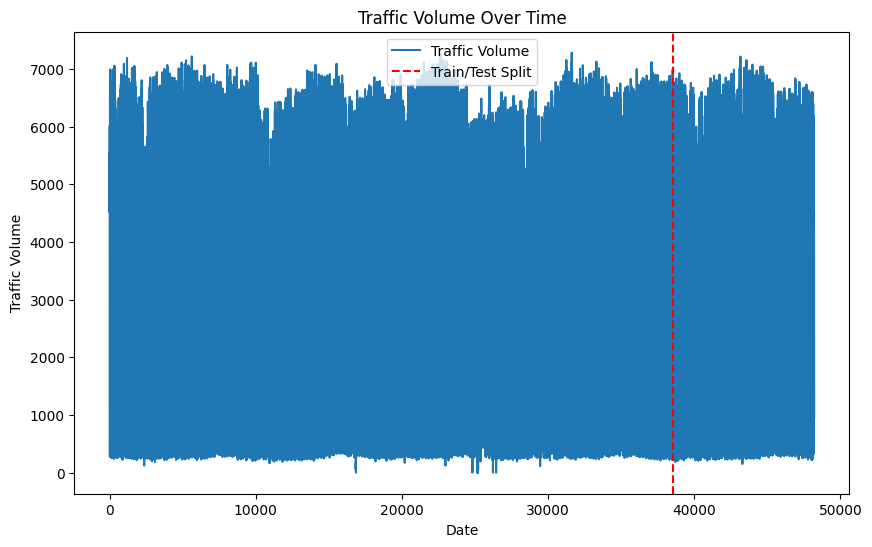

In [4]:
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=",", parse_dates=['date_time'])
data['traffic_volume'] = pd.to_numeric(data['traffic_volume'], errors='coerce')

n = int(len(data) * 4 / 5)
train = data[:n]
test = data[n:]


plt.figure(figsize=(10, 6))
plt.plot(data['traffic_volume'], label='Traffic Volume')
plt.axvline(x=n, color='red', linestyle='--', label='Train/Test Split')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


### SARIMA model

In [42]:
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 24   # Seasonal parameters (assuming weekly seasonality)

model = SARIMAX(train['traffic_volume'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                38563
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -310694.754
Date:                            Tue, 10 Dec 2024   AIC                         621399.507
Time:                                    21:56:04   BIC                         621442.304
Sample:                                         0   HQIC                        621413.078
                                          - 38563                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2699      0.011     25.198      0.000       0.249       0.291
ma.L1          0.1070      0.011   

In [50]:
forecast = results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

mse = mean_squared_error(test['traffic_volume'], forecast.predicted_mean)
r2 = r2_score(test['traffic_volume'], forecast.predicted_mean)
# print(f'Mean Squared Error for the SARIMA model: {mse}, r2: {r2}, execution time: {results.model.endog.shape[0]}')
print(f'Mean Squared Error for the SARIMA model: {mse}, r2: {r2}, execution time: 9.5 min')

Mean Squared Error for the SARIMA model: 7082734.982121836, r2: -0.8293501990177263, execution time: 9.5 min


### TBATS Model

In [ ]:
from tbats import TBATS
estimator = TBATS(seasonal_periods=[24, 168])  # Daily and weekly seasonality

model = estimator.fit(train['traffic_volume'])

# Make predictions
forecast_steps = 24  # Number of steps to forecast
y_forecasted = model.forecast(steps=len(test))

In [48]:
mse = mean_squared_error(test['traffic_volume'], y_forecasted)
r2 = r2_score(test['traffic_volume'], y_forecasted)
# print(f'Mean Squared Error: {mse}, execution time: {model._execution_time}')
print(f'Mean Squared Error: {mse}, r2: {r2}, execution time: 58min')

Mean Squared Error: 3899290.783849774, r2: -0.0071206094071056825, execution time: 58min


| Model                         | MSE          | R²           |Execution Time|
|-------------------------------|--------------|--------------|--|
| SARIMA             | 7,082,734   | -0.82        | 9.5 min |
| TBATS     | 3,899,290    | -0.0071        | 58 min| 

### Interpretation

Best Performing Model: The TBATS model is the best performing model with the highest R² score (-0.0071) and the lowest MSE (3,899,290), indicating the most accurate predictions.

Worst Performing Model: The SARIMA model performed the worst with a relatively low R² score (-0.82) and high MSE (7,082,734), indicating less accurate predictions compared to the TBATS model.

#### Note on R² Scores

It is important to note that both models have very poor R² scores, which are negative. An R² score of 0 indicates that the model does not explain any of the variability of the response data around its mean. Negative R² scores suggest that the model performs worse than a simple mean model. This indicates that neither model is particularly effective at capturing the underlying patterns in the data. Further model tuning or exploration of alternative models may be necessary to improve performance.

#### Comparison with Previous Models

When comparing the TBATS and SARIMA models against previously evaluated models, it becomes evident that both TBATS and SARIMA perform significantly worse. The previous models, such as CatBoostRegressor, GradientBoostingRegressor, and XGBRegressor, all have R² scores above 0.97 and MSE values well below 120,000. This stark contrast highlights the ineffectiveness of TBATS and SARIMA for this particular dataset.

### Hyperparameters

#### SARIMA Model
Here are the hyperparameters that can be tuned for the SARIMA model:
- *order*: The (p,d,q) order of the model for the ARIMA component.
- *seasonal_order*: The (P,D,Q,s) order of the seasonal component.
- *trend*: The trend component to include in the model.
- *measurement_error*: Whether to include a measurement error component.
- *time_varying_regression*: Whether to include a time-varying regression component.
- *mle_regression*: Whether to use maximum likelihood estimation for regression.
- *enforce_stationarity*: Whether to enforce stationarity in the model.

The only hyperparameter we tuned for the SARIMA model was the seasonal_order, which specifies the seasonal component of the model. We set the seasonal_order to (1, 1, 1, 24) to capture the daily seasonality in the data.

#### TBATS Model
Here are the hyperparameters that can be tuned for the TBATS model:
- *use_box_cox*: Whether to use Box-Cox transformation.
- *box_cox_bounds*: Bounds for the Box-Cox transformation parameter.
- *use_trend*: Whether to include a trend component.
- *use_damped_trend*: Whether to include a damped trend component.
- *seasonal_periods*: List of seasonal periods to include in the model. --> this is the only hyperparameter we tuned
- *use_arma_errors*: Whether to include ARMA errors.
- *show_warnings*: Whether to show warnings during model fitting.

Unfortunately, we didn't use and techniques to tune the hyperparameters of the TBATS model because it is a very complex model and it would take a lot of time and computation resources to run. We decided to keep the default values.


### Conclusion

These results suggest that ensemble methods like CatBoostRegressor and GradientBoostingRegressor are highly effective for this particular dataset. The CatBoostRegressor stands out as the top performer, making it the preferred choice for this regression task. The TBATS and SARIMA models, with their negative R² scores and high MSE values, are not suitable for this dataset and require further tuning or alternative approaches.